# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
from numpy.fft import *
import datetime

import matplotlib.pyplot as plt
import yaml
import datetime as dt
import scipy
import warnings

from itertools import product

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA, AutoTheta, AutoCES
from statsforecast.utils import ConformalIntervals

from prophet import Prophet

import tensorflow as tf

import joblib

warnings.filterwarnings("ignore")

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Lecture du jeu de données

In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  float64
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  float64
 7   atm             447136 non-null  float64
 8   col             447136 non-null  float64
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  float64
 13  prof            447136 non-null  float64
 14  plan            447136 non-null  float64
 15  surf            447136 non-null  float64
 16  infra           447136 non-null  float64
 17  situ           

### Séléction des colonnes qui nous intéressent ('jour', 'mois', 'an', 'grav')

In [4]:
liste = ['lum', 'dep', 'agg', 'int', 'atm', 'col', 'lat',
       'long', 'catr', 'circ', 'prof', 'plan', 'surf', 'infra', 'situ',
       'sexe', 'catv', 'obs', 'obsm', 'manv', 'motor', 'grav_rec', 'date',
       'weekend', 'heure', 'place_rec', 'age_usager', 'eq_ceinture',
       'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag', 'eq_gants',
       'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
df = df.drop(liste, axis = 1)
df.head()

jour  mois    an  grav
0    30    11  2019   4.0
1    30    11  2019   4.0
2    30    11  2019   1.0
3    30    11  2019   4.0
4    28    11  2019   1.0

### Sélection des lignes où grav = 3 (pour les blessés hospitalisés)

In [5]:
df_bh = df[df['grav'] == 3]
df_bh.head()

jour  mois    an  grav
28    29    11  2019   3.0
51    29    11  2019   3.0
55    29    11  2019   3.0
64    25    11  2019   3.0
65    30    11  2019   3.0

### Création de la série temporelle

In [6]:
y_m_j = df_bh['an'].astype('str') + "-" + df_bh['mois'].astype('str') + "-" + df_bh['jour'].astype('str')
df_bh.insert(loc = 0, column = 'y_m_j', value = y_m_j)
df_bh['y_m_j'] = pd.to_datetime(df_bh['y_m_j'])
df_bh = df_bh.drop(['an', 'mois', 'jour'], axis = 1)
df_bh.head()

y_m_j  grav
28 2019-11-29   3.0
51 2019-11-29   3.0
55 2019-11-29   3.0
64 2019-11-25   3.0
65 2019-11-30   3.0

In [7]:
df_bh['Nbre_Acc'] = 1
df_bh = df_bh.drop('grav', axis = 1)
df_bh = df_bh[['y_m_j', 'Nbre_Acc']].groupby('y_m_j').sum().reset_index()
df_bh.head()

y_m_j  Nbre_Acc
0 2019-01-01        53
1 2019-01-02        36
2 2019-01-03        46
3 2019-01-04        39
4 2019-01-05        46

In [8]:
df_bh = df_bh.set_index('y_m_j')
df_bh.head()


Nbre_Acc
y_m_j               
2019-01-01        53
2019-01-02        36
2019-01-03        46
2019-01-04        39
2019-01-05        46

# Etude de la tendance, de la saisonnalité et du bruit pour les années 2020 à 2022

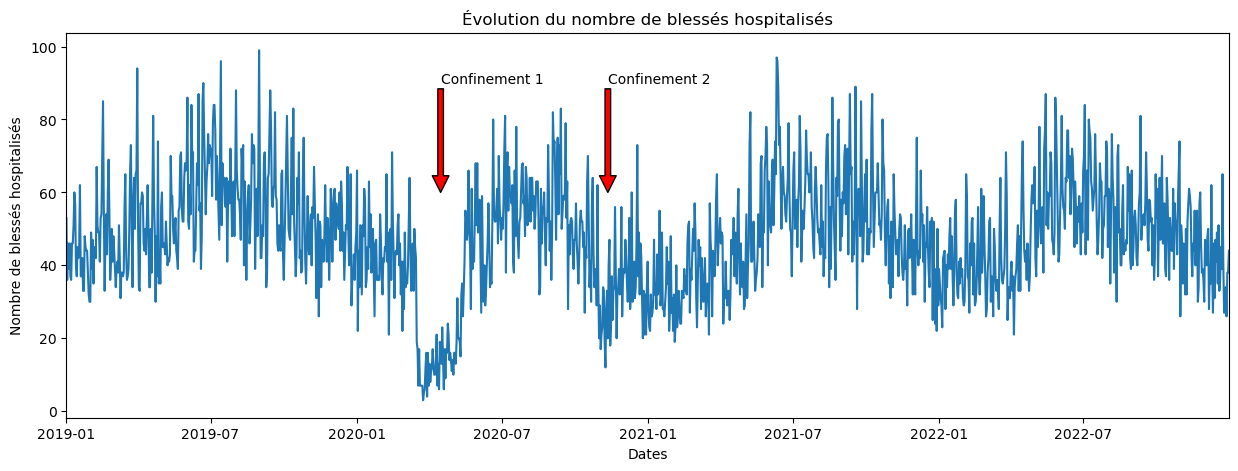

In [9]:
plt.figure(figsize = (15, 5))
plt.plot(df_bh)
plt.xlabel('Dates')
plt.ylabel("Nombre de blessés hospitalisés")
plt.title("Évolution du nombre de blessés hospitalisés")
plt.xlim(df_bh.index[0], df_bh.index[-1])
plt.annotate('Confinement 1', xy = (df_bh.index[470], 60), xytext = (df_bh.index[470], 90), arrowprops = {'facecolor' : 'red'})
plt.annotate('Confinement 2', xy = (df_bh.index[680], 60), xytext = (df_bh.index[680], 90), arrowprops = {'facecolor' : 'red'})
plt.show()

On voit une diminution du nombre de tué en 2020, certainement due aux confinement de mars et octobre.
Pour ne pas biaiser le jeu de donnée, nous allons nous concentrer sur les années 2021 et 2022.

In [10]:
df_bh = df_bh[df_bh.index >= '2021-01-01']
df_bh
df2 = df_bh.copy()

### Visualisation du nombre de tués en fonction du jour

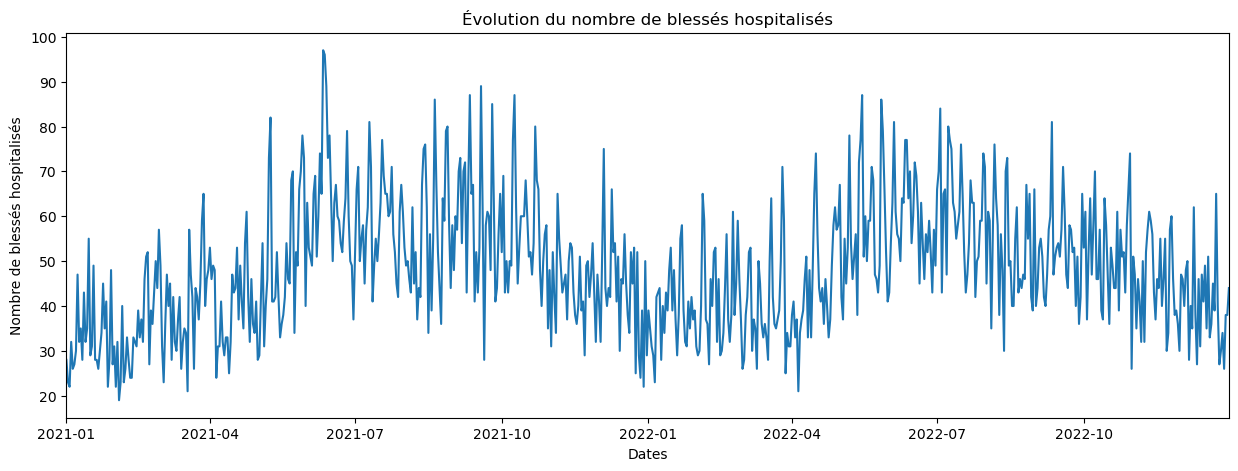

In [11]:
plt.figure(figsize = (15, 5))
plt.plot(df_bh)
plt.xlabel('Dates')
plt.ylabel("Nombre de blessés hospitalisés")
plt.title("Évolution du nombre de blessés hospitalisés")
plt.xlim(df_bh.index[0], df_bh.index[-1])
plt.show()

La courbe montre que l'écart les points maximaux et les points minimaux n'augmente pas. On est dans le cas d'un modèle additif.

### La tendance

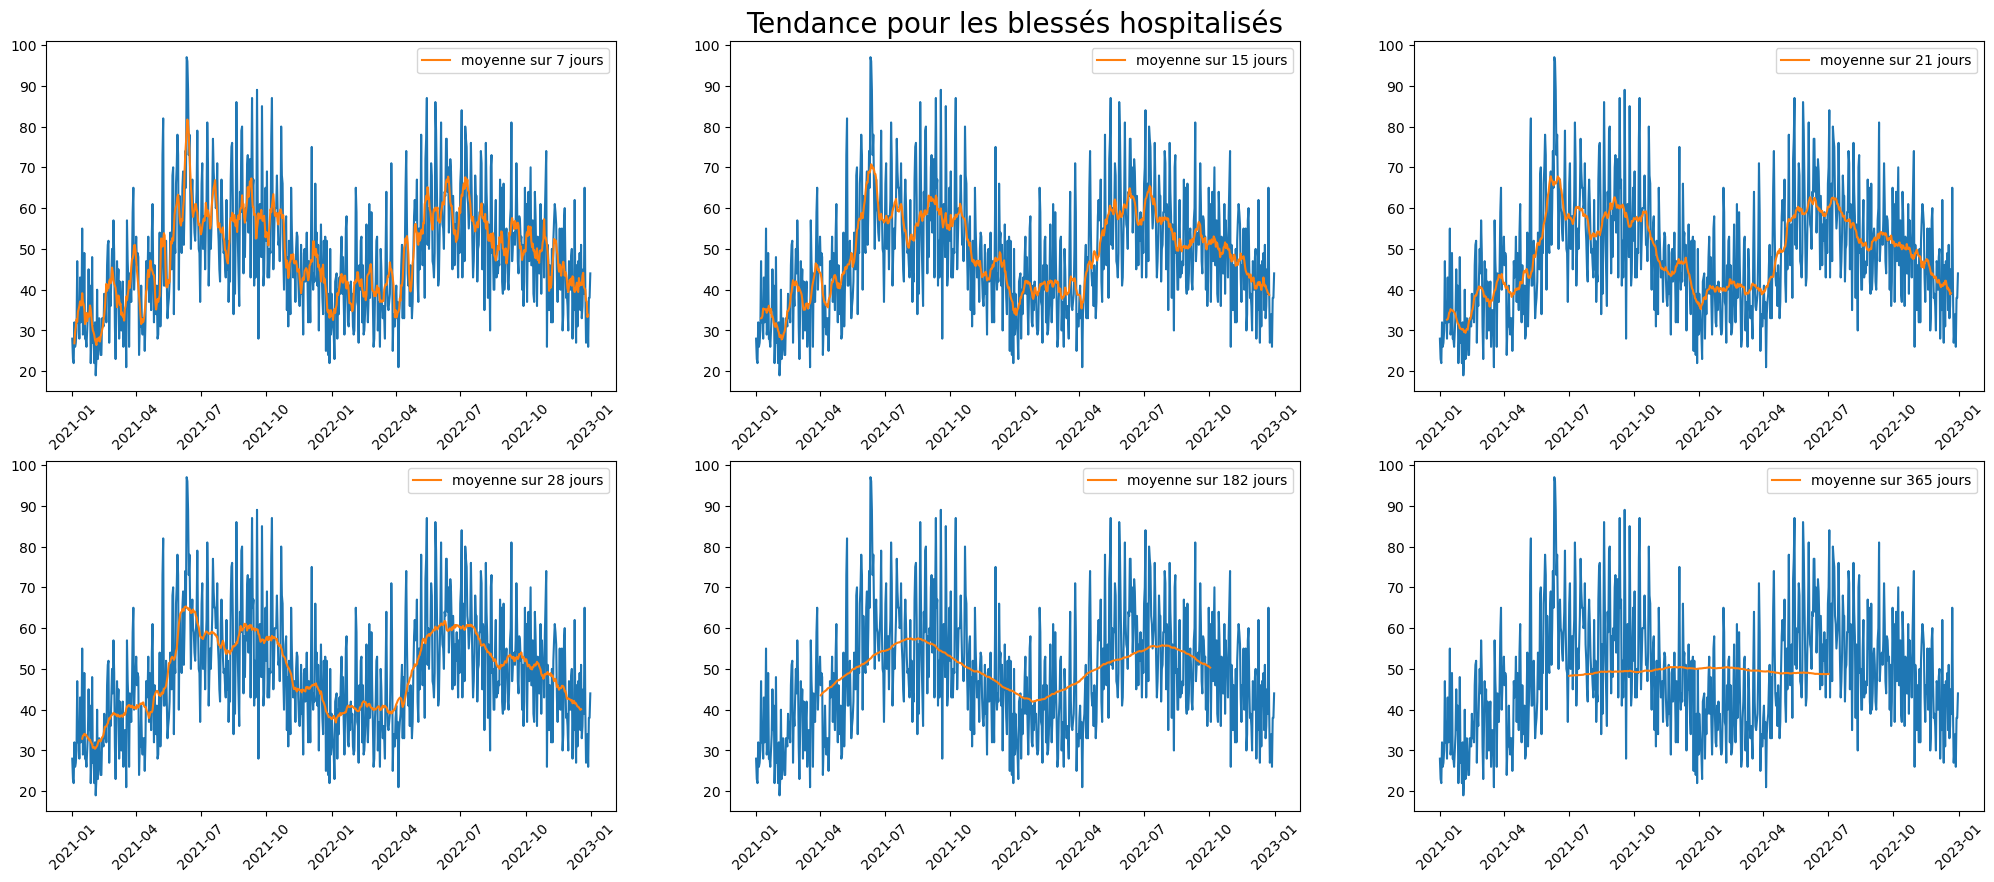

In [12]:
win = [7, 15, 21, 28, 182, 365]
fig = plt.figure(figsize = (25, 10))
plt.title("Tendance pour les blessés hospitalisés", {'fontsize' : 20})
plt.axis('off')

for i in range(len(win)):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(df_bh)
    ax.plot(df_bh.rolling(win[i], center = True).mean(), label = f"moyenne sur {win[i]} jours")
    ax.tick_params(axis = 'x', labelrotation = 45)
    ax.legend()
    

plt.show()

En prenant un fenêtre de 365 jours, une tendance linéaire et stable est bien visible.   
Le fait que cette tendance est identifiable pour des fenêtre glissante dont la taille est un multiple de 365 mois suggère une notion de saisonnalité annuelle.

### La saisonnalité

In [13]:
df_bh['an'] = df_bh.index.year
df_bh['jour_semaine'] = df_bh.index.day_name()
df_bh

Nbre_Acc    an jour_semaine
y_m_j                                  
2021-01-01        28  2021       Friday
2021-01-02        23  2021     Saturday
2021-01-03        22  2021       Sunday
2021-01-04        32  2021       Monday
2021-01-05        26  2021      Tuesday
...              ...   ...          ...
2022-12-27        34  2022      Tuesday
2022-12-28        26  2022    Wednesday
2022-12-29        38  2022     Thursday
2022-12-30        38  2022       Friday
2022-12-31        44  2022     Saturday

[730 rows x 3 columns]

In [14]:
df_bh_moy = df_bh[['an', 'jour_semaine', 'Nbre_Acc']].groupby(['an', 'jour_semaine']).mean().reset_index()
df_bh_moy

an jour_semaine   Nbre_Acc
0   2021       Friday  53.735849
1   2021       Monday  40.961538
2   2021     Saturday  56.807692
3   2021       Sunday  51.230769
4   2021     Thursday  46.096154
5   2021      Tuesday  45.576923
6   2021    Wednesday  43.557692
7   2022       Friday  55.346154
8   2022       Monday  43.269231
9   2022     Saturday  57.905660
10  2022       Sunday  52.884615
11  2022     Thursday  44.365385
12  2022      Tuesday  42.634615
13  2022    Wednesday  44.788462

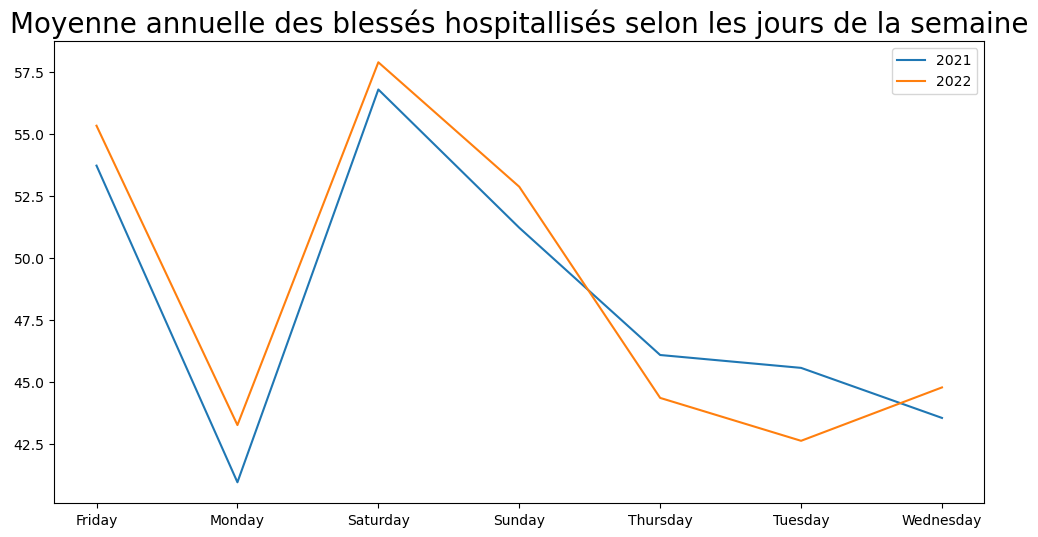

In [15]:
plt.figure(figsize = (12, 6))

yrs = df_bh_moy['an'].unique()

for i in yrs :
    plt.plot(df_bh_moy['jour_semaine'][df_bh_moy['an'] == i], df_bh_moy["Nbre_Acc"][df_bh_moy['an'] == i], label = i)

plt.legend(bbox_to_anchor = (1, 1)) 
plt.title('Moyenne annuelle des blessés hospitallisés selon les jours de la semaine', {'fontsize' : 20})
plt.show()

In [16]:
df_bh = df_bh.drop(['an', 'jour_semaine'], axis = 1)
df_bh.head()

Nbre_Acc
y_m_j               
2021-01-01        28
2021-01-02        23
2021-01-03        22
2021-01-04        32
2021-01-05        26

Les variations du nombre de tués sur une année ont une tendance similaire. Il semblerait que l'on ait une saisonnalité.

### Le bruit

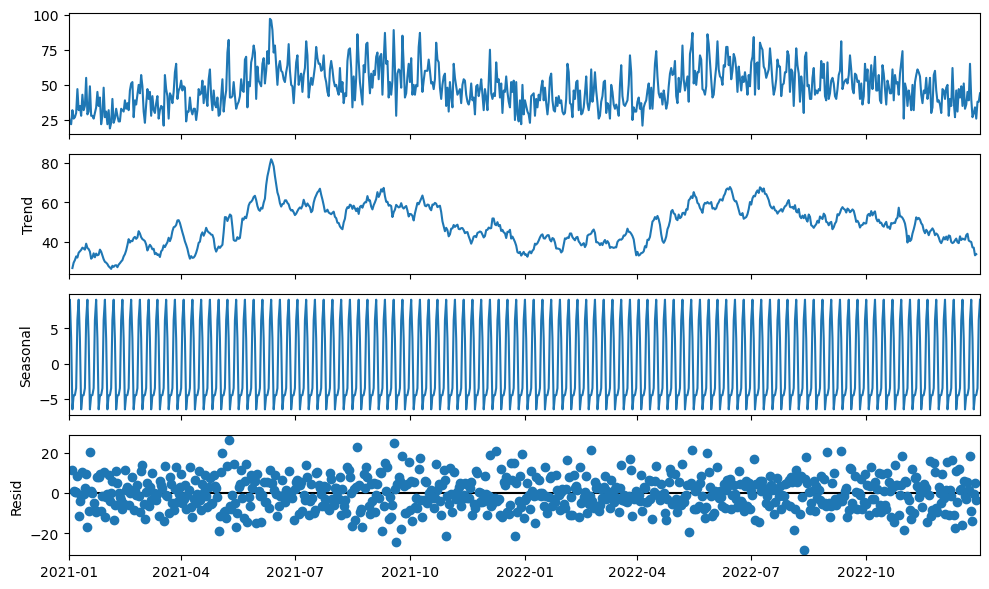

In [17]:
res = seasonal_decompose(df_bh, model = 'additive')
fig = res.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

Le bruit est important. Il faudra sûrement faire une différenciation.

# Création d'une baseline avec une méthode naïve

### Création de la colonne Nbre_Acc_t-1

In [18]:
df_naive = df_bh
df_naive['Nbre_Acc_t-1'] = df_naive['Nbre_Acc'].shift(1)
df_naive

Nbre_Acc  Nbre_Acc_t-1
y_m_j                             
2021-01-01        28           NaN
2021-01-02        23          28.0
2021-01-03        22          23.0
2021-01-04        32          22.0
2021-01-05        26          32.0
...              ...           ...
2022-12-27        34          30.0
2022-12-28        26          34.0
2022-12-29        38          26.0
2022-12-30        38          38.0
2022-12-31        44          38.0

[730 rows x 2 columns]

In [19]:
df_naive = df_naive.dropna()
df_naive

Nbre_Acc  Nbre_Acc_t-1
y_m_j                             
2021-01-02        23          28.0
2021-01-03        22          23.0
2021-01-04        32          22.0
2021-01-05        26          32.0
2021-01-06        27          26.0
...              ...           ...
2022-12-27        34          30.0
2022-12-28        26          34.0
2022-12-29        38          26.0
2022-12-30        38          38.0
2022-12-31        44          38.0

[729 rows x 2 columns]

In [20]:
# Sauvegarde du DataFrame
df_naive.to_csv("../../../data/saved_models/Blesses_hospitalises_Baseline_shift1.csv")

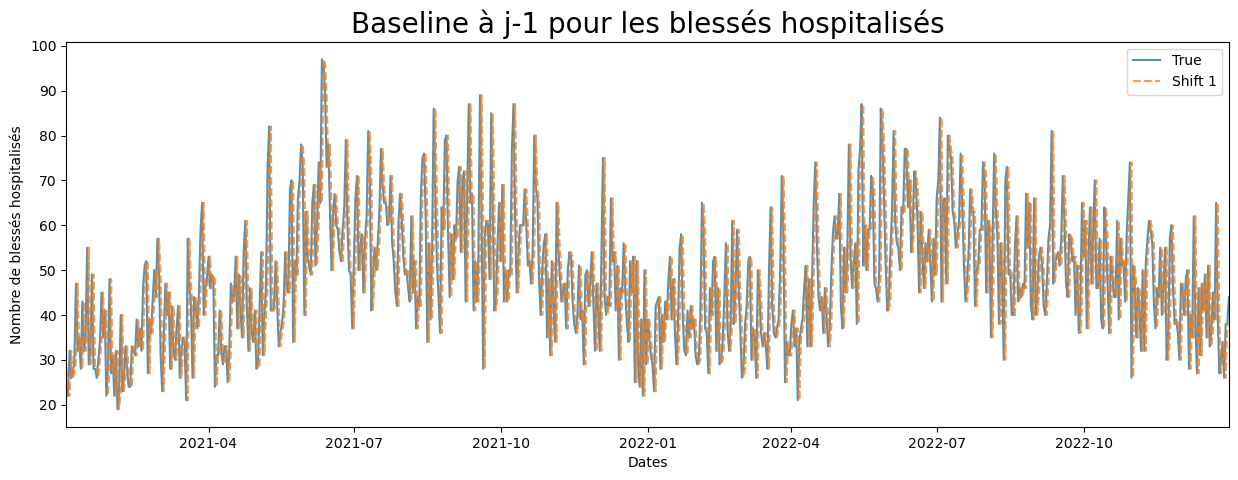

In [21]:
plt.figure(figsize = (15, 5))
plt.plot(df_naive.index, df_naive['Nbre_Acc'], alpha = 0.8, label = 'True')
plt.plot(df_naive.index, df_naive['Nbre_Acc_t-1'], alpha = 0.8, label = 'Shift 1', linestyle = "dashed")
plt.legend()
plt.xlim(df_naive.index[0], df_naive.index[-1])
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés hospitalisés')
plt.title("Baseline à j-1 pour les blessés hospitalisés", {'fontsize' : 20})
plt.show()

In [22]:
true = df_naive['Nbre_Acc']
prediction = df_naive['Nbre_Acc_t-1']

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(true, prediction)
train_mse = mean_squared_error(true, prediction)
train_rmse = mean_squared_error(true, prediction, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
})

print(performance_df)

  Métrique  Ensemble d'entraînement
0      MAE                10.672154
1      MSE               181.706447
2     RMSE                13.479853


### Création de la colonne Nbre_Acc_rm (moyenne des 7 jours précédents)

In [23]:
df_naive = df_bh
df_naive['Nbre_Acc_t-1'] = df_naive['Nbre_Acc'].rolling(7).mean().shift(1)
df_naive

Nbre_Acc  Nbre_Acc_t-1
y_m_j                             
2021-01-01        28           NaN
2021-01-02        23           NaN
2021-01-03        22           NaN
2021-01-04        32           NaN
2021-01-05        26           NaN
...              ...           ...
2022-12-27        34     40.285714
2022-12-28        26     40.000000
2022-12-29        38     37.285714
2022-12-30        38     37.142857
2022-12-31        44     33.285714

[730 rows x 2 columns]

In [24]:
df_naive = df_naive.dropna()
df_naive

Nbre_Acc  Nbre_Acc_t-1
y_m_j                             
2021-01-08        47     26.857143
2021-01-09        32     29.571429
2021-01-10        35     30.857143
2021-01-11        28     32.714286
2021-01-12        43     32.142857
...              ...           ...
2022-12-27        34     40.285714
2022-12-28        26     40.000000
2022-12-29        38     37.285714
2022-12-30        38     37.142857
2022-12-31        44     33.285714

[723 rows x 2 columns]

In [25]:
# Sauvegarde du DataFrame
df_naive.to_csv("../../../data/saved_models/Blesses_hospitalises_Baseline_moy7+shift1.csv")

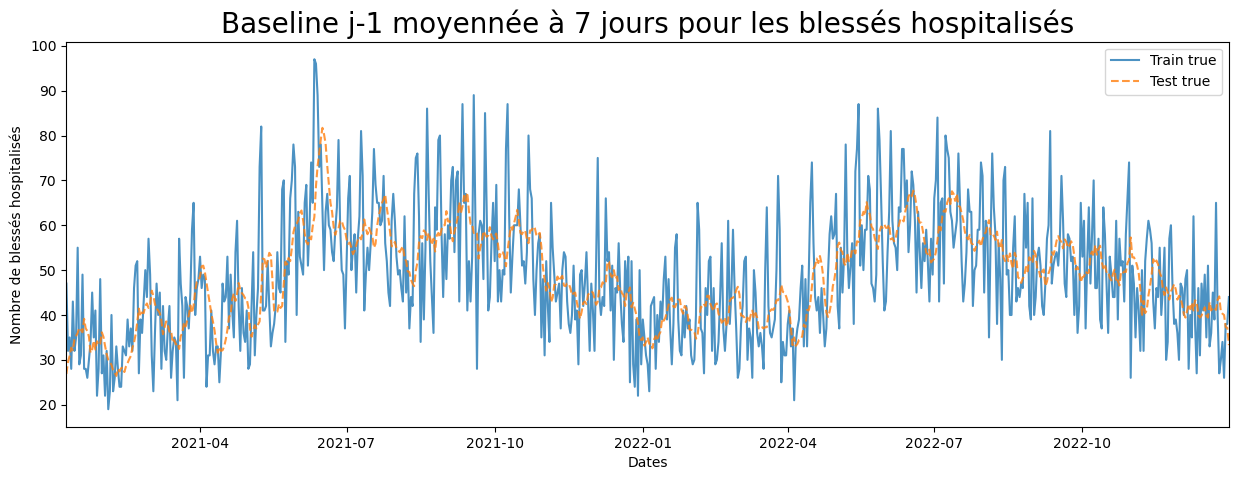

In [26]:
plt.figure(figsize = (15, 5))
plt.plot(df_naive.index, df_naive['Nbre_Acc'], alpha = 0.8, label = 'Train true')
plt.plot(df_naive.index, df_naive['Nbre_Acc_t-1'], alpha = 0.8, label = 'Test true', linestyle = "dashed")
plt.legend()
plt.xlim(df_naive.index[0], df_naive.index[-1])
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés hospitalisés')
plt.title("Baseline j-1 moyennée à 7 jours pour les blessés hospitalisés", {'fontsize' : 20})
plt.show()

In [27]:
true = df_naive['Nbre_Acc']
prediction = df_naive['Nbre_Acc_t-1']

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(true, prediction)
train_mse = mean_squared_error(true, prediction)
train_rmse = mean_squared_error(true, prediction, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
})

print(performance_df)

  Métrique  Ensemble d'entraînement
0      MAE                 9.179806
1      MSE               134.236232
2     RMSE                11.586036


# Entraînement et évaluation d'un modèle SARIMAX

In [28]:
df_bh = df_bh.drop('Nbre_Acc_t-1', axis = 1)
df_bh.head()

Nbre_Acc
y_m_j               
2021-01-01        28
2021-01-02        23
2021-01-03        22
2021-01-04        32
2021-01-05        26

In [29]:
# Sauvegarde du DataFrame
df_bh.to_csv("../../../data/saved_models/Blesses_hospitalises_Sarimax.csv")

### Stationarisation de la série

In [30]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        
check_stationarity(df_bh)

ADF Statistic: -2.199468
p-value: 0.206439
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Non-stationary


On fait une différenciation d'ordre 1 pour stationnariser.

In [31]:
df_bh_1 = df_bh.diff().dropna()
check_stationarity(df_bh_1)

ADF Statistic: -9.862097
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Stationary


### Vérification de la saisonnalité à 365 jours

Méthodologie issue de : https://www.kaggle.com/code/saisatishmasina/sarima-with-fourier-terms
pour l'analyse de la qualité de l'air

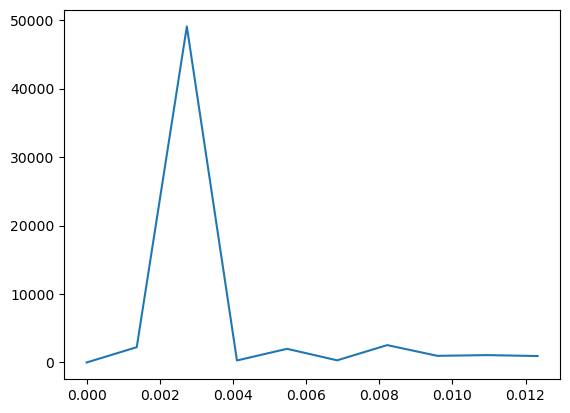

In [32]:
freq, PSD = scipy.signal.periodogram(df_bh['Nbre_Acc'].values)
plt.plot(freq[:10], PSD[:10]) # checking the lower frequencies

In [33]:
periodogram = pd.DataFrame({"Period": (1/freq), "Power Spectral Density": PSD}).round(2)

periodogram[:10]

Period  Power Spectral Density
0     inf                    0.00
1  730.00                 2232.54
2  365.00                49083.15
3  243.33                  293.62
4  182.50                 1994.99
5  146.00                  314.09
6  121.67                 2537.28
7  104.29                  970.57
8   91.25                 1076.48
9   81.11                  941.20

In [34]:
""" Confirme la saisonnalité de 365 jours"""

' Confirme la saisonnalité de 365 jours'

### Séparation en train et test

In [35]:
train, test = train_test_split(df_bh, test_size = 0.1, shuffle = False)

In [36]:
x = train['Nbre_Acc'].values

### Extrapolation de la série de Fourier

In [37]:
def fourierExtrapolation(x, n_predict):
    n = x.size
    
    n_harm = 20                     # number of harmonics in model
    
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    
    x_notrend = x - p[0] * t        # detrended x
    
    x_freqdom = fft(x_notrend)  # detrended x in frequency domain
    f = fftfreq(n)              # frequencies
    
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    
    return restored_sig + p[0] * t

exog = fourierExtrapolation(x, len(test))

print("Shape of Exogenous Regressor (Fourier Extraction) for seasonality: ", exog.shape)

Shape of Exogenous Regressor (Fourier Extraction) for seasonality:  (730,)


In [38]:
train.shape[0]+test.shape[0]

730

In [39]:
train['exog'] = exog[:len(train)]
test['exog'] = exog[len(train):]

### Courbes d'Autocorrélation et d'Autocorrélation partielle

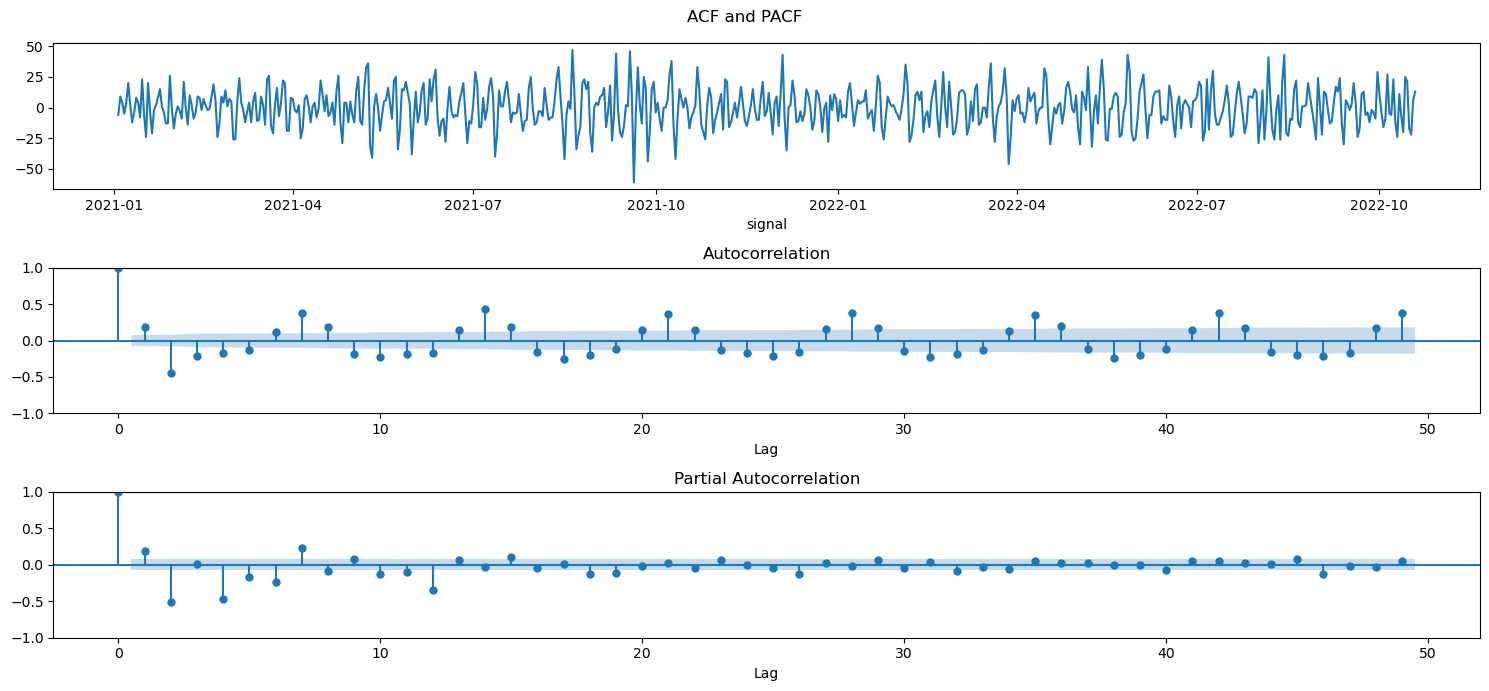

In [40]:
Ndiff=2
signal=train.Nbre_Acc.diff(Ndiff).dropna()

# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(311)
ax.set_xlabel("signal")
plt.plot(signal)

ax = plt.subplot(312)
ax.set_xlabel("Lag")
sm.graphics.tsa.plot_acf(signal, lags=49, ax=ax)

ax = plt.subplot(313)
ax.set_xlabel("Lag")
sm.graphics.tsa.plot_pacf(signal, lags=49, ax=ax)

plt.suptitle("ACF and PACF")
plt.tight_layout()
plt.show()

### Entraînement du modèle et résultats

In [41]:
# Initial approximation of parameters
Qs = range(0,3) 
qs = range(0,3)
Ps = range(0,3)
ps = range(0,3)
D=1
d=2

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


def bestmodel(parameters_list, df):
    # Model Selection
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')

    for param in parameters_list:
        
        try:
            model=sm.tsa.statespace.SARIMAX(train.Nbre_Acc, exog=train['exog'],order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 7), enforce_stationarity=False).fit(disp=-1)
        except ValueError:
            print('wrong parameters:', param)
            continue

        aic = model.aic

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        
        results.append([param, model.aic])
    return results, best_model

results, best_model = bestmodel(parameters_list, train)

In [42]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters (p,q,P,Q)', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

   parameters (p,q,P,Q)          aic
74         (2, 2, 0, 2)  4612.291502
77         (2, 2, 1, 2)  4612.770626
50         (1, 2, 1, 2)  4613.953958
23         (0, 2, 1, 2)  4618.193192
47         (1, 2, 0, 2)  4619.379024
                                     SARIMAX Results                                     
Dep. Variable:                          Nbre_Acc   No. Observations:                  657
Model:             SARIMAX(2, 2, 2)x(0, 1, 2, 7)   Log Likelihood               -2298.146
Date:                           Thu, 30 May 2024   AIC                           4612.292
Time:                                   14:52:26   BIC                           4647.870
Sample:                               01-01-2021   HQIC                          4626.110
                                    - 10-19-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|    

On voit que le P>|z| de ar.L2 est supérieur à 5%. On essaie donc le modèle SARIMAX(1, 2, 2)x(0, 1, 2, 7)

In [43]:
model = sm.tsa.statespace.SARIMAX(train.Nbre_Acc, exog=train['exog'], order = (1, 2, 2), seasonal_order = (0, 1, 1, 7), enforce_stationarity=False)
sarimax = model.fit(disp = -1)
print(sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Nbre_Acc   No. Observations:                  657
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 7)   Log Likelihood               -2331.522
Date:                             Thu, 30 May 2024   AIC                           4675.045
Time:                                     14:52:27   BIC                           4701.795
Sample:                                 01-01-2021   HQIC                          4685.429
                                      - 10-19-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog           1.0018      0.054     18.396      0.000       0.895       1.109
ar.L1          0.1347      

In [44]:
joblib.dump(sarimax, "../../../data/saved_models/Blesses_hospitalises_Sarimax.joblib")

['../../../data/saved_models/Blesses_hospitalises_Sarimax.joblib']

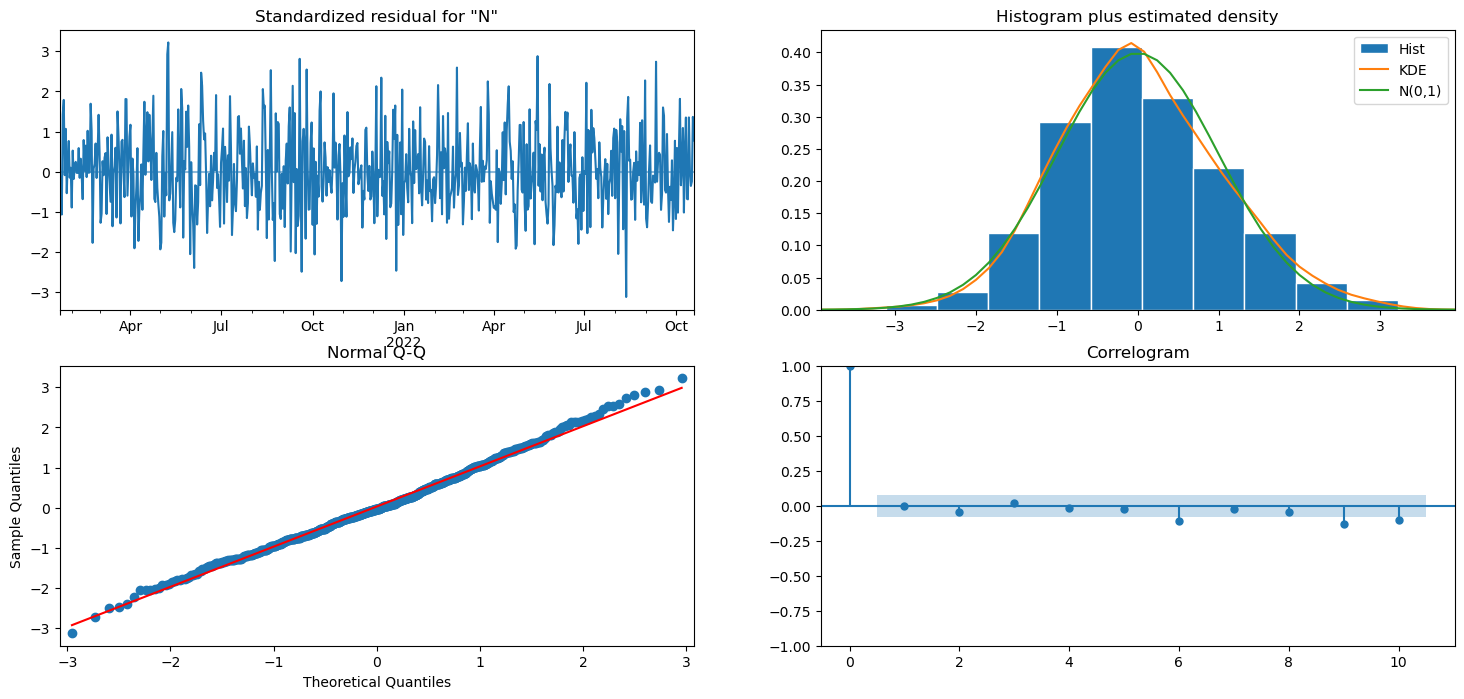

In [45]:
sarimax.plot_diagnostics(figsize=(18, 8))
plt.show()

### Évaluation du modèle

Text(0, 0.5, 'Num_Acc')

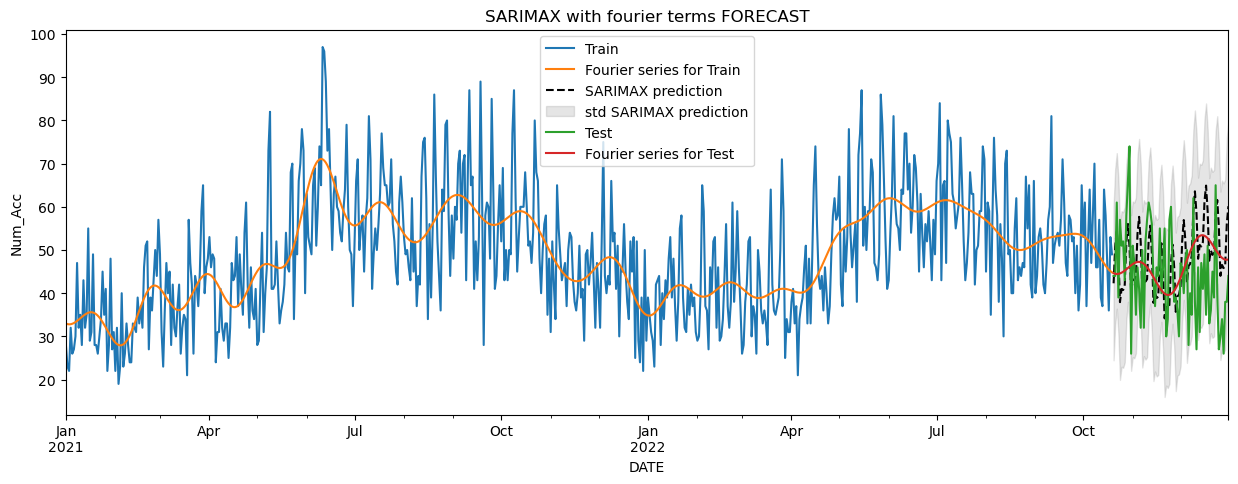

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train.plot(ax=ax)

# Construct the forecasts
fcast = sarimax.get_forecast(len(test), exog= test['exog']).summary_frame()
fcast.index = test.index
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)

test.plot(ax=ax)

plt.title("SARIMAX with fourier terms FORECAST")
plt.legend(["Train", "Fourier series for Train", "SARIMAX prediction", "std SARIMAX prediction", "Test", "Fourier series for Test"])
plt.xlabel("DATE")
plt.ylabel("Num_Acc")

Text(0, 0.5, 'Num_Acc')

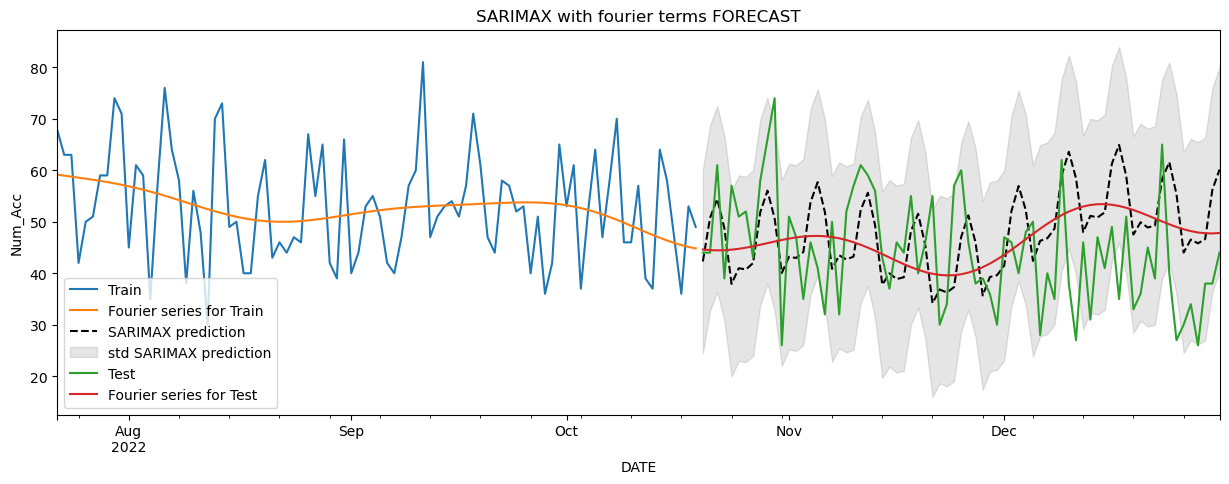

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train[-90 : ].plot(ax=ax)

# Construct the forecasts
fcast = sarimax.get_forecast(len(test), exog= test['exog']).summary_frame()
fcast.index = test.index
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)

test.plot(ax=ax)

plt.title("SARIMAX with fourier terms FORECAST")
plt.legend(["Train", "Fourier series for Train", "SARIMAX prediction", "std SARIMAX prediction", "Test", "Fourier series for Test"])
plt.xlabel("DATE")
plt.ylabel("Num_Acc")

In [48]:
train_predictions = sarimax.get_forecast(len(train), exog= train['exog']).summary_frame()['mean']
test_predictions = sarimax.get_forecast(len(test), exog= test['exog']).summary_frame()['mean']

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['Nbre_Acc'], train_predictions)
train_mse = mean_squared_error(train['Nbre_Acc'], train_predictions)
train_rmse = mean_squared_error(train['Nbre_Acc'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['Nbre_Acc'], test_predictions)
test_mse = mean_squared_error(test['Nbre_Acc'], test_predictions)
test_rmse = mean_squared_error(test['Nbre_Acc'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                14.751434         10.864034
1      MSE               317.853746        168.030073
2     RMSE                17.828453         12.962641


Erreurs avec la série de Fourier

In [49]:
true_values = test.Nbre_Acc.values
pred_values = test.exog.values

test_mae_fourier = mean_absolute_error(y_pred=pred_values, y_true=true_values)
test_mse_fourier = mean_squared_error(y_pred=pred_values, y_true=true_values)
test_rmse_fourier = mean_squared_error(y_pred=pred_values, y_true=true_values, squared=False)

print("MAE: ",test_mae_fourier)
print("MSE: ",test_mse_fourier)
print("RMSE: ",test_rmse_fourier)

MAE:  10.08394838719801
MSE:  150.15145436619494
RMSE:  12.253630252549444


### Prévisions

On ne peut pas faire de prévisions car on ne peut pas prédire la série de Fourier pour la mettre en exog dans SARIMAX.

# Entraînement et évaluation d'un modèle MSTL

### Preparation du jeu de données

In [50]:
df_bh2 = df2
df_bh2 = df_bh2.reset_index()
df_bh2

y_m_j  Nbre_Acc
0   2021-01-01        28
1   2021-01-02        23
2   2021-01-03        22
3   2021-01-04        32
4   2021-01-05        26
..         ...       ...
725 2022-12-27        34
726 2022-12-28        26
727 2022-12-29        38
728 2022-12-30        38
729 2022-12-31        44

[730 rows x 2 columns]

In [51]:
df_bh2 = df_bh2.rename(columns = {'y_m_j' : 'ds', 'Nbre_Acc' : 'y'})
df_bh2['unique_id'] = "1"
df_bh2.head()

ds   y unique_id
0 2021-01-01  28         1
1 2021-01-02  23         1
2 2021-01-03  22         1
3 2021-01-04  32         1
4 2021-01-05  26         1

In [52]:
df_bh2 = df_bh2[df_bh2['ds'] >= '2021-01-01'].reset_index()
df_bh2 = df_bh2.drop('index', axis = 1)
df_bh2.head()

ds   y unique_id
0 2021-01-01  28         1
1 2021-01-02  23         1
2 2021-01-03  22         1
3 2021-01-04  32         1
4 2021-01-05  26         1

In [53]:
# Sauvegarde du DataFrame
df_bh2.to_csv("../../../data/saved_models/Blesses_hospitalises_MSTL.csv")

### Exploration du jeu de données

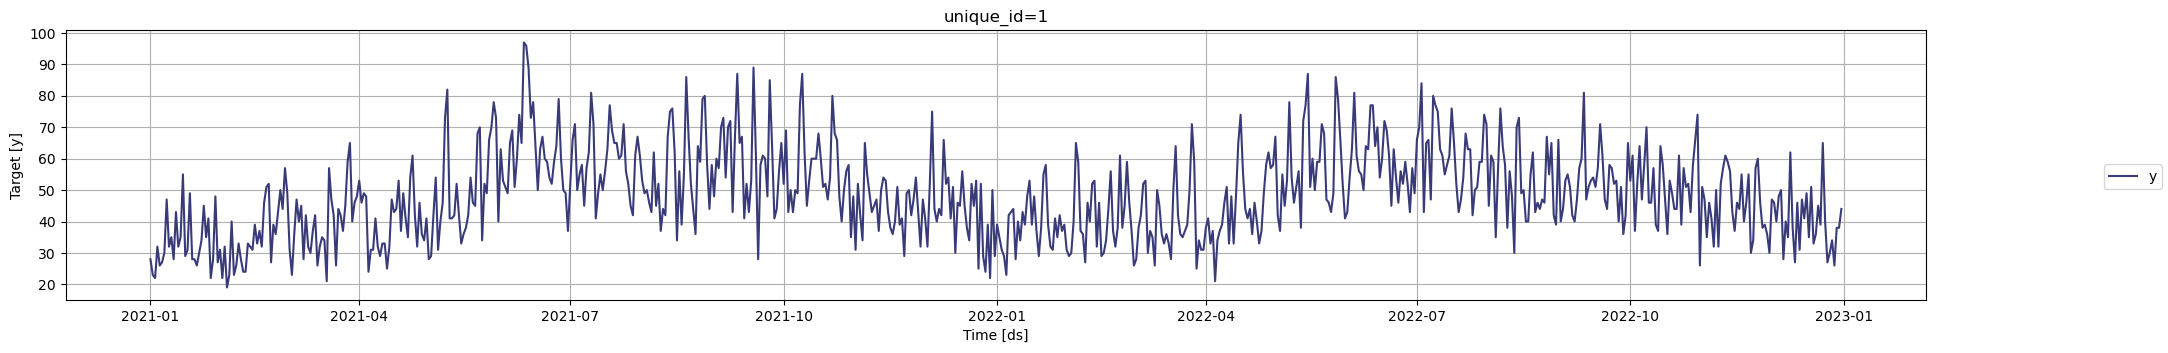

In [54]:
StatsForecast.plot(df_bh2)

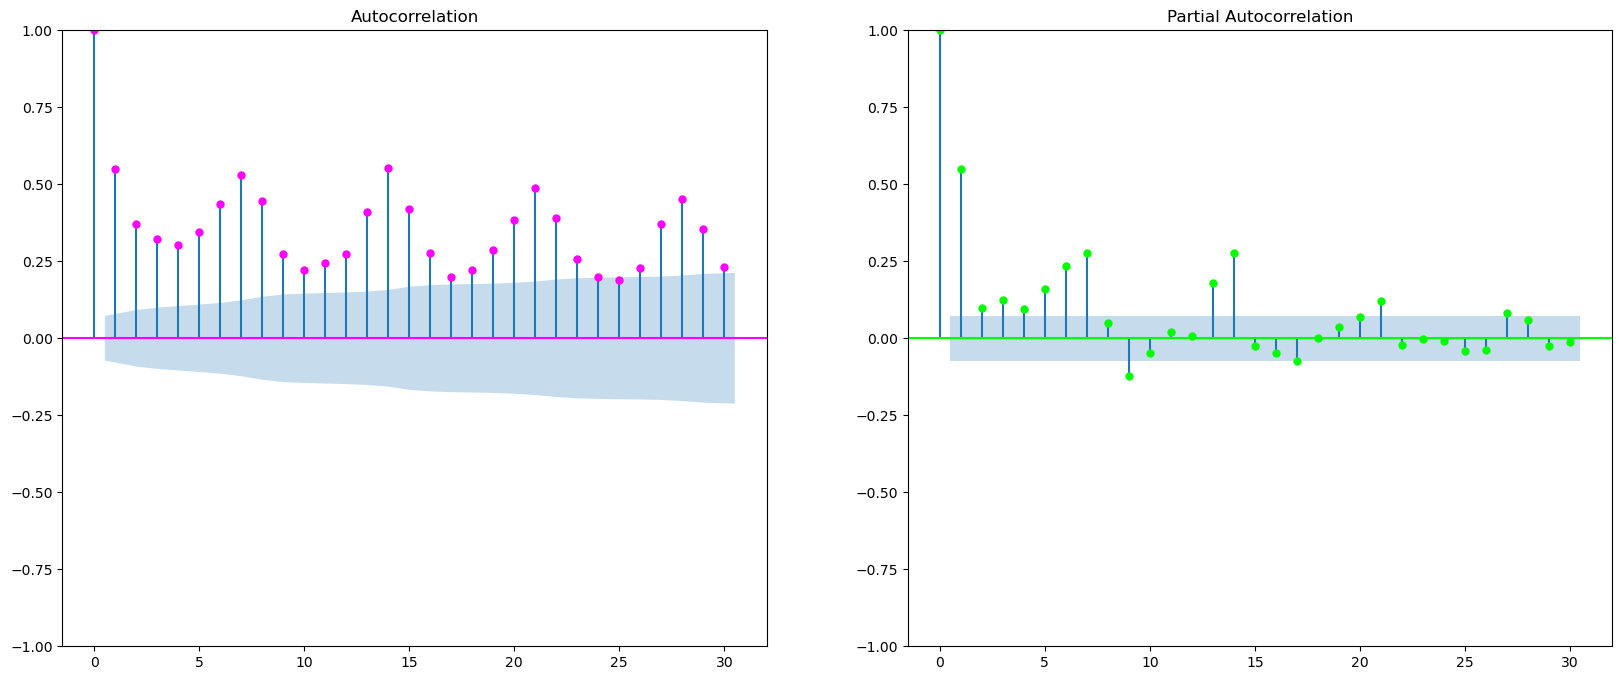

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))

plot_acf(df_bh2["y"], lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation")

# Grafico
plot_pacf(df_bh2["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show()

On voit bien la saisonnalité sur 7 jours.

### Séparation en train et test

In [56]:
train, test = train_test_split(df_bh2, test_size = 0.1, shuffle = False)

In [57]:
train.shape, test.shape

((657, 3), (73, 3))

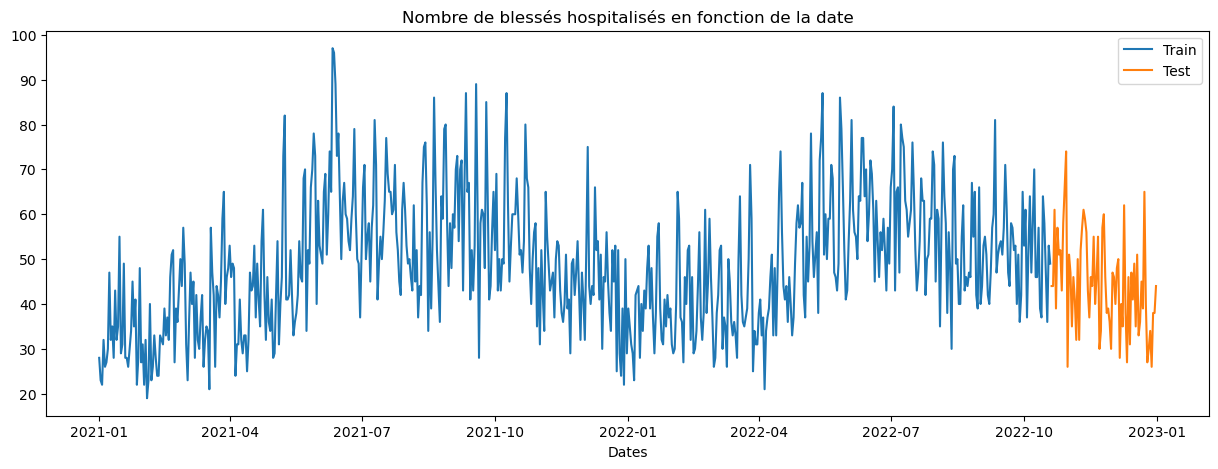

In [58]:
plt.figure(figsize=(15, 5))
plt.plot(train["ds"], train["y"], label = "Train")
plt.plot(test["ds"], test["y"], label="Test")
plt.title("Nombre de blessés hospitalisés en fonction de la date")
plt.xlabel("Dates")
plt.legend()
plt.show()

### Implémentation du modèle MSTL avec AutoARIMA comme trend_forecaster

In [59]:
horizon = len(test)

models = [MSTL(season_length=[7, 7 * 52], 
               trend_forecaster=AutoARIMA(prediction_intervals=ConformalIntervals(n_windows=3, h=horizon)))]

In [60]:
sf = StatsForecast(models = models,
                   freq = 'D',     
                   n_jobs = -1)

• Entraînement du modèle

In [61]:
sf.fit(df = train)

StatsForecast(models=[MSTL])

In [62]:
result=sf.fitted_[0,0].model_
result

data      trend  seasonal7  seasonal364  remainder
0    28.0  45.318311   8.703096   -25.475721  -0.545687
1    23.0  45.335121  -1.397192   -21.026681   0.088752
2    22.0  45.351919   1.427484   -18.418447  -6.360955
3    32.0  45.368707   0.280534   -14.719748   1.070506
4    26.0  45.385484   0.932582   -18.791148  -1.526918
..    ...        ...        ...          ...        ...
652  58.0  46.882537   4.789949     5.668562   0.658952
653  47.0  46.869244   7.423368    -0.478627  -6.813985
654  36.0  46.855931  -6.967818     2.888967  -6.777081
655  53.0  46.842600  -2.278058     8.804327  -0.368869
656  49.0  46.829250  -4.134550     3.343726   2.961574

[657 rows x 5 columns]

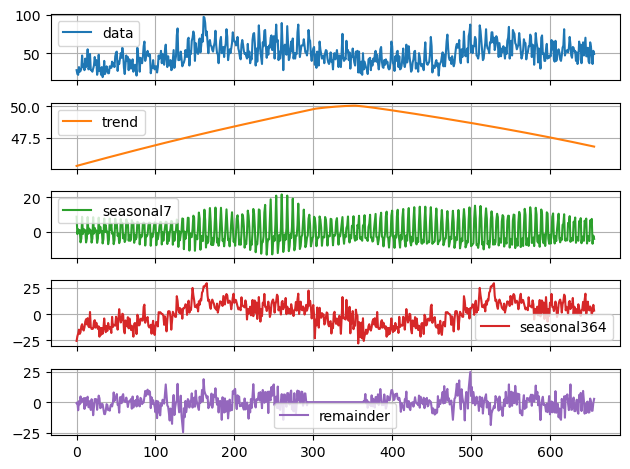

In [63]:
sf.fitted_[0, 0].model_.tail(7 * 52 * 2).plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

In [64]:
Y_test_pred = sf.forecast(horizon, fitted=True)
Y_test_pred

ds       MSTL
unique_id                      
1         2022-10-20  46.487103
1         2022-10-21  75.359940
1         2022-10-22  59.674232
1         2022-10-23  66.104790
1         2022-10-24  45.672581
...              ...        ...
1         2022-12-27  35.763596
1         2022-12-28  18.912727
1         2022-12-29  36.798950
1         2022-12-30  27.227596
1         2022-12-31  29.868813

[73 rows x 2 columns]

In [65]:
values = sf.forecast_fitted_values()
values.head()

ds     y       MSTL
unique_id                            
1         2021-01-01  28.0  27.955227
1         2021-01-02  23.0  22.501333
1         2021-01-03  22.0  27.294018
1         2021-01-04  32.0  28.640457
1         2021-01-05  26.0  26.333305

In [66]:
Y_test_pred = Y_test_pred.reset_index()
Y_test_pred

unique_id         ds       MSTL
0          1 2022-10-20  46.487103
1          1 2022-10-21  75.359940
2          1 2022-10-22  59.674232
3          1 2022-10-23  66.104790
4          1 2022-10-24  45.672581
..       ...        ...        ...
68         1 2022-12-27  35.763596
69         1 2022-12-28  18.912727
70         1 2022-12-29  36.798950
71         1 2022-12-30  27.227596
72         1 2022-12-31  29.868813

[73 rows x 3 columns]

In [67]:
Y_test_pred1 = Y_test_pred.merge(right = test, how = 'inner', on = ['ds', 'unique_id'])
Y_test_pred1

unique_id         ds       MSTL   y
0          1 2022-10-20  46.487103  44
1          1 2022-10-21  75.359940  44
2          1 2022-10-22  59.674232  61
3          1 2022-10-23  66.104790  39
4          1 2022-10-24  45.672581  57
..       ...        ...        ...  ..
68         1 2022-12-27  35.763596  34
69         1 2022-12-28  18.912727  26
70         1 2022-12-29  36.798950  38
71         1 2022-12-30  27.227596  38
72         1 2022-12-31  29.868813  44

[73 rows x 4 columns]

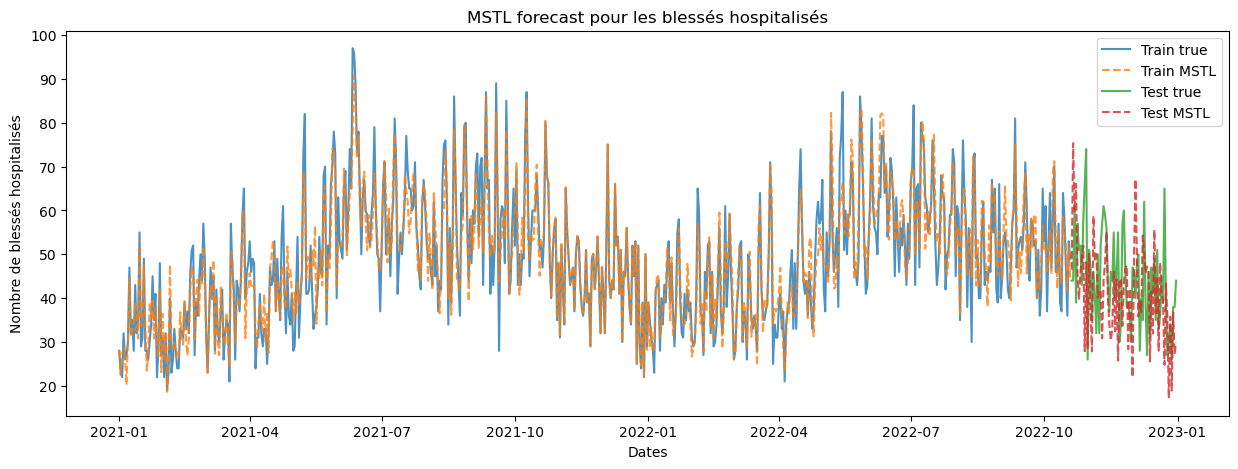

In [68]:
plt.figure(figsize = (15, 5))
plt.plot(values['ds'], values['y'], alpha = 0.8, label = 'Train true')
plt.plot(values['ds'], values['MSTL'], alpha = 0.8, label = 'Train MSTL', linestyle = "dashed")
plt.plot(Y_test_pred1['ds'], Y_test_pred1['y'], alpha = 0.8, label = 'Test true')
plt.plot(Y_test_pred1['ds'], Y_test_pred1['MSTL'], alpha = 0.8, label = 'Test MSTL', linestyle = "dashed")
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés hospitalisés')
plt.title("MSTL forecast pour les blessés hospitalisés")
plt.show()

In [69]:
fcast = sf.forecast(h=horizon, level=[95])
fcast

ds       MSTL  MSTL-lo-95  MSTL-hi-95
unique_id                                              
1         2022-10-20  46.487103   41.396637   51.577572
1         2022-10-21  75.359940   69.361763   81.358109
1         2022-10-22  59.674232   55.550289   63.798172
1         2022-10-23  66.104790   59.406410   72.803169
1         2022-10-24  45.672581   29.500767   61.844391
...              ...        ...         ...         ...
1         2022-12-27  35.763596   33.560928   37.966263
1         2022-12-28  18.912727   10.050546   27.774908
1         2022-12-29  36.798950   28.252430   45.345467
1         2022-12-30  27.227596   17.603596   36.851597
1         2022-12-31  29.868813   22.739504   36.998119

[73 rows x 4 columns]

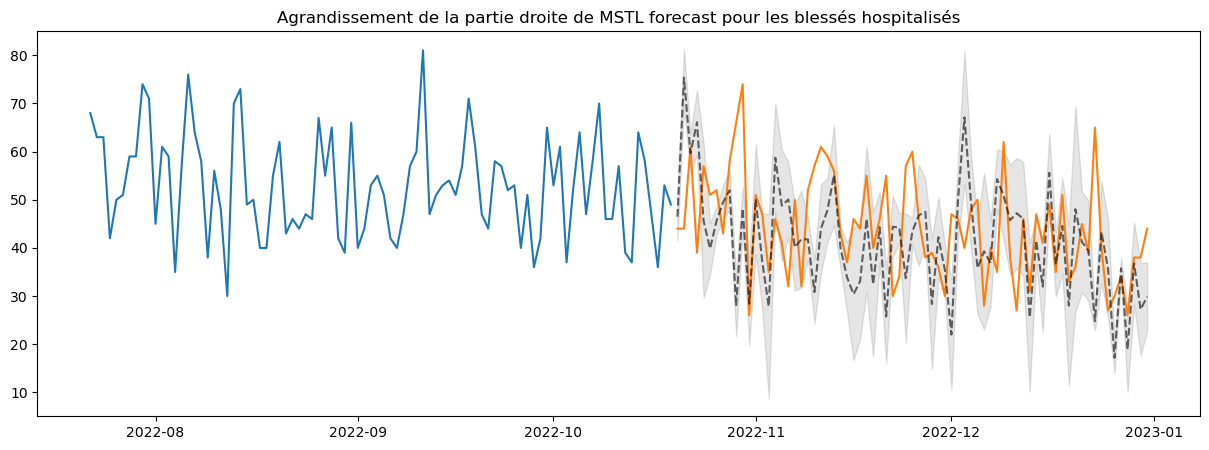

In [70]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(values['ds'][-90 :], values['y'][-90 :], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(fcast['ds'], fcast['MSTL'], "k--",label = 'Test MSTL', alpha = 0.6)
ax.fill_between(fcast['ds'], fcast['MSTL-lo-95'], fcast['MSTL-hi-95'], color='k', alpha=0.1)
ax.set_title("Agrandissement de la partie droite de MSTL forecast pour les blessés hospitalisés")
plt.show()

• Evaluation du modèle

In [71]:
train_predictions = values['MSTL']
test_predictions = Y_test_pred1['MSTL']

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['y'], train_predictions)
train_mse = mean_squared_error(train['y'], train_predictions)
train_rmse = mean_squared_error(train['y'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['y'], test_predictions)
test_mse = mean_squared_error(test['y'], test_predictions)
test_rmse = mean_squared_error(test['y'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                 4.262655         10.807208
1      MSE                31.265702        197.560835
2     RMSE                 5.591574         14.055634


• Prédiction pour les 6 premiers mois de 2023

Réentraînement du modèle sur tout le jeu de données

In [72]:
sf.fit(df = df_bh2)

StatsForecast(models=[MSTL])

Prédiction pour les 6 prochains mois

In [73]:
horizon = 181

In [74]:
Y_pred = sf.forecast(horizon, fitted=True)
Y_pred

ds       MSTL
unique_id                      
1         2023-01-01  30.085457
1         2023-01-02  33.496067
1         2023-01-03  21.325907
1         2023-01-04  28.252226
1         2023-01-05  36.286705
...              ...        ...
1         2023-06-26  57.744362
1         2023-06-27  39.861683
1         2023-06-28  50.037792
1         2023-06-29  55.929424
1         2023-06-30  72.925041

[181 rows x 2 columns]

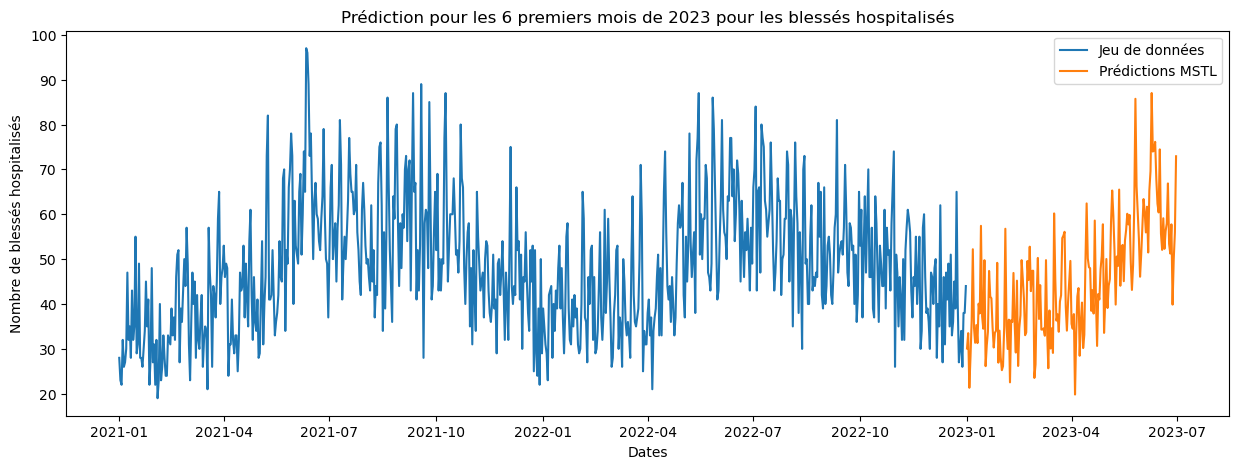

In [75]:
plt.figure(figsize = (15, 5))
plt.plot(df_bh2['ds'], df_bh2['y'], label = 'Jeu de données')
plt.plot(Y_pred['ds'], Y_pred['MSTL'], label = 'Prédictions MSTL')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés hospitalisés')
plt.title("Prédiction pour les 6 premiers mois de 2023 pour les blessés hospitalisés")
plt.show()

### Implémentation du modèle MSTL avec AutoTheta comme trend_forecaster

In [76]:
horizon = len(test)

models = [MSTL(season_length=[7, 7 * 52], 
               trend_forecaster=AutoTheta(prediction_intervals=ConformalIntervals(n_windows=3, h=horizon)))]


In [77]:
sf = StatsForecast(models = models,
                   freq = 'D',     # Pour weekly frequency
                   n_jobs = -1)

• Entraînement du modèle

In [78]:
sf.fit(df = train)

StatsForecast(models=[MSTL])

In [79]:
Y_test_pred = sf.forecast(horizon, fitted=True)
Y_test_pred

ds       MSTL
unique_id                      
1         2022-10-20  45.914665
1         2022-10-21  74.157234
1         2022-10-22  58.108372
1         2022-10-23  65.104073
1         2022-10-24  44.633450
...              ...        ...
1         2022-12-27  34.912144
1         2022-12-28  18.062817
1         2022-12-29  35.950584
1         2022-12-30  26.380777
1         2022-12-31  29.023539

[73 rows x 2 columns]

In [80]:
values = sf.forecast_fitted_values()
values.head()

ds     y       MSTL
unique_id                            
1         2021-01-01  28.0  36.526051
1         2021-01-02  23.0  29.201141
1         2021-01-03  22.0  33.417191
1         2021-01-04  32.0  33.727226
1         2021-01-05  26.0  29.970051

In [81]:
Y_test_pred = Y_test_pred.reset_index()
Y_test_pred

unique_id         ds       MSTL
0          1 2022-10-20  45.914665
1          1 2022-10-21  74.157234
2          1 2022-10-22  58.108372
3          1 2022-10-23  65.104073
4          1 2022-10-24  44.633450
..       ...        ...        ...
68         1 2022-12-27  34.912144
69         1 2022-12-28  18.062817
70         1 2022-12-29  35.950584
71         1 2022-12-30  26.380777
72         1 2022-12-31  29.023539

[73 rows x 3 columns]

In [82]:
Y_test_pred1 = Y_test_pred.merge(right = test, how = 'inner', on = ['ds', 'unique_id'])
Y_test_pred1

unique_id         ds       MSTL   y
0          1 2022-10-20  45.914665  44
1          1 2022-10-21  74.157234  44
2          1 2022-10-22  58.108372  61
3          1 2022-10-23  65.104073  39
4          1 2022-10-24  44.633450  57
..       ...        ...        ...  ..
68         1 2022-12-27  34.912144  34
69         1 2022-12-28  18.062817  26
70         1 2022-12-29  35.950584  38
71         1 2022-12-30  26.380777  38
72         1 2022-12-31  29.023539  44

[73 rows x 4 columns]

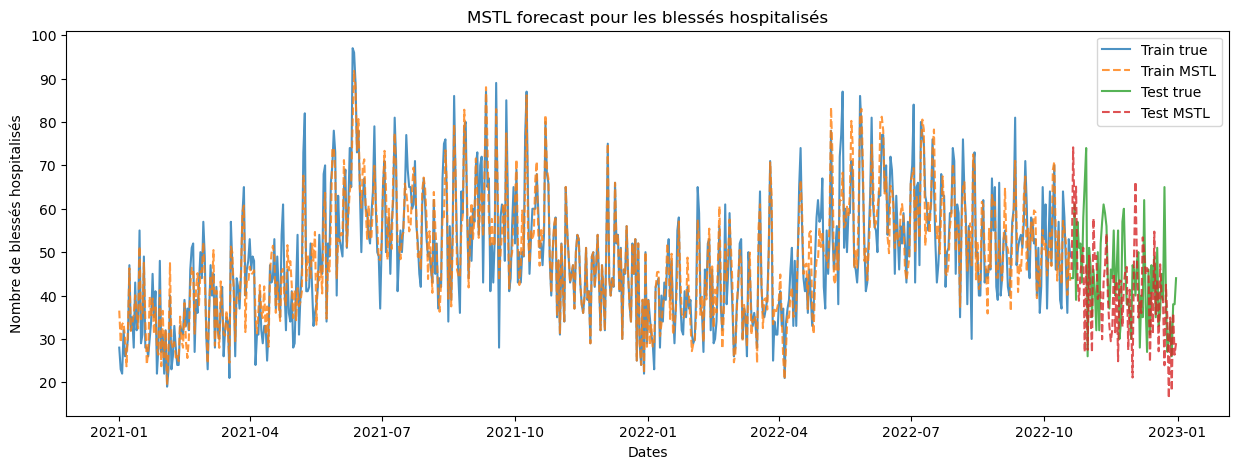

In [83]:
plt.figure(figsize = (15, 5))
plt.plot(values['ds'], values['y'], alpha = 0.8, label = 'Train true')
plt.plot(values['ds'], values['MSTL'], alpha = 0.8, label = 'Train MSTL', linestyle = "dashed")
plt.plot(Y_test_pred1['ds'], Y_test_pred1['y'], alpha = 0.8, label = 'Test true')
plt.plot(Y_test_pred1['ds'], Y_test_pred1['MSTL'], alpha = 0.8, label = 'Test MSTL', linestyle = "dashed")
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés hospitalisés')
plt.title("MSTL forecast pour les blessés hospitalisés")
plt.show()

In [84]:
fcast = sf.forecast(h=horizon, level=[95])
fcast

ds       MSTL  MSTL-lo-95  MSTL-hi-95
unique_id                                              
1         2022-10-20  45.914665   41.170177   50.659153
1         2022-10-21  74.157234   67.442314   80.872147
1         2022-10-22  58.108372   54.766911   61.449833
1         2022-10-23  65.104073   56.098461   74.109688
1         2022-10-24  44.633450   26.374207   62.892693
...              ...        ...         ...         ...
1         2022-12-27  34.912144   29.491173   40.333111
1         2022-12-28  18.062817    6.232234   29.893400
1         2022-12-29  35.950584   24.097486   47.803680
1         2022-12-30  26.380777   14.423532   38.338024
1         2022-12-31  29.023539   20.980169   37.066906

[73 rows x 4 columns]

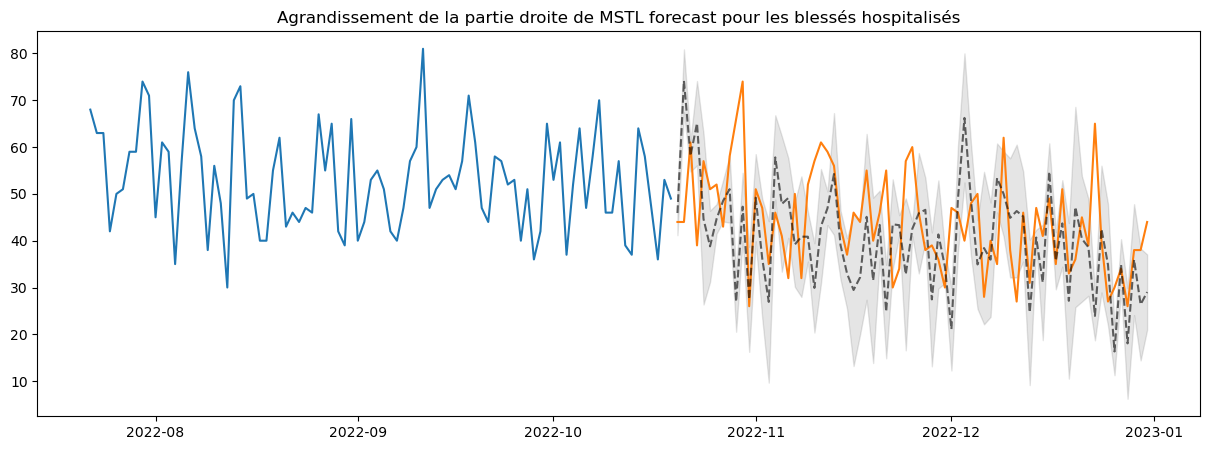

In [85]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(values['ds'][-90 :], values['y'][-90 :], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(fcast['ds'], fcast['MSTL'], "k--",label = 'Test MSTL', alpha = 0.6)
ax.fill_between(fcast['ds'], fcast['MSTL-lo-95'], fcast['MSTL-hi-95'], color='k', alpha=0.1)
ax.set_title("Agrandissement de la partie droite de MSTL forecast pour les blessés hospitalisés")
plt.show()

• Evaluation du modèle

In [86]:
train_predictions = values['MSTL']
test_predictions = Y_test_pred1['MSTL']

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['y'], train_predictions)
train_mse = mean_squared_error(train['y'], train_predictions)
train_rmse = mean_squared_error(train['y'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['y'], test_predictions)
test_mse = mean_squared_error(test['y'], test_predictions)
test_rmse = mean_squared_error(test['y'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                 4.383491         11.019847
1      MSE                33.323198        203.412977
2     RMSE                 5.772625         14.262292


• Prédiction pour les 6 premiers mois de 2023

Réentraînement du modèle sur tout le jeu de données

In [87]:
sf.fit(df = df_bh2)

StatsForecast(models=[MSTL])

Prédiction pour les 6 prochains mois

In [88]:
horizon = 181

In [89]:
Y_pred = sf.forecast(horizon, fitted=True)
Y_pred

ds       MSTL
unique_id                      
1         2023-01-01  30.661753
1         2023-01-02  34.892403
1         2023-01-03  21.720819
1         2023-01-04  29.777077
1         2023-01-05  38.105114
...              ...        ...
1         2023-06-26  59.961910
1         2023-06-27  42.080242
1         2023-06-28  52.257362
1         2023-06-29  58.150009
1         2023-06-30  75.146637

[181 rows x 2 columns]

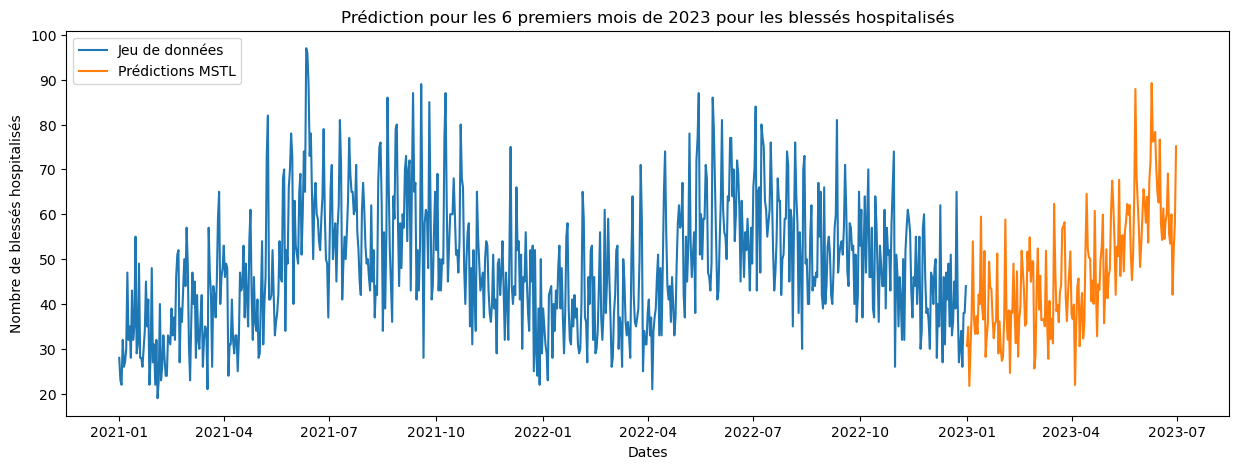

In [90]:
plt.figure(figsize = (15, 5))
plt.plot(df_bh2['ds'], df_bh2['y'], label = 'Jeu de données')
plt.plot(Y_pred['ds'], Y_pred['MSTL'], label = 'Prédictions MSTL')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés hospitalisés')
plt.title("Prédiction pour les 6 premiers mois de 2023 pour les blessés hospitalisés")
plt.show()

### Implémentation du modèle MSTL avec AutoCES comme trend_forecaster

In [91]:
horizon = len(test)

models = [MSTL(season_length=[7, 7 * 52], 
               trend_forecaster=AutoCES(prediction_intervals=ConformalIntervals(n_windows=3, h=horizon)))]


In [92]:
sf = StatsForecast(models = models,
                   freq = 'D',     # Pour weekly frequency
                   n_jobs = -1)

• Entraînement du modèle

In [93]:
sf.fit(df = train)

StatsForecast(models=[MSTL])

In [94]:
Y_test_pred = sf.forecast(horizon, fitted=True)
Y_test_pred

ds       MSTL
unique_id                      
1         2022-10-20  45.828106
1         2022-10-21  74.048714
1         2022-10-22  57.983189
1         2022-10-23  64.961197
1         2022-10-24  44.473091
...              ...        ...
1         2022-12-27  33.642349
1         2022-12-28  16.775867
1         2022-12-29  34.646488
1         2022-12-30  25.059538
1         2022-12-31  27.685163

[73 rows x 2 columns]

In [95]:
values = sf.forecast_fitted_values()
values.head()

ds     y       MSTL
unique_id                            
1         2021-01-01  28.0  28.098991
1         2021-01-02  23.0  22.412270
1         2021-01-03  22.0  27.944870
1         2021-01-04  32.0  29.311890
1         2021-01-05  26.0  26.410492

In [96]:
Y_test_pred = Y_test_pred.reset_index()
Y_test_pred

unique_id         ds       MSTL
0          1 2022-10-20  45.828106
1          1 2022-10-21  74.048714
2          1 2022-10-22  57.983189
3          1 2022-10-23  64.961197
4          1 2022-10-24  44.473091
..       ...        ...        ...
68         1 2022-12-27  33.642349
69         1 2022-12-28  16.775867
70         1 2022-12-29  34.646488
71         1 2022-12-30  25.059538
72         1 2022-12-31  27.685163

[73 rows x 3 columns]

In [97]:
Y_test_pred1 = Y_test_pred.merge(right = test, how = 'inner', on = ['ds', 'unique_id'])
Y_test_pred1

unique_id         ds       MSTL   y
0          1 2022-10-20  45.828106  44
1          1 2022-10-21  74.048714  44
2          1 2022-10-22  57.983189  61
3          1 2022-10-23  64.961197  39
4          1 2022-10-24  44.473091  57
..       ...        ...        ...  ..
68         1 2022-12-27  33.642349  34
69         1 2022-12-28  16.775867  26
70         1 2022-12-29  34.646488  38
71         1 2022-12-30  25.059538  38
72         1 2022-12-31  27.685163  44

[73 rows x 4 columns]

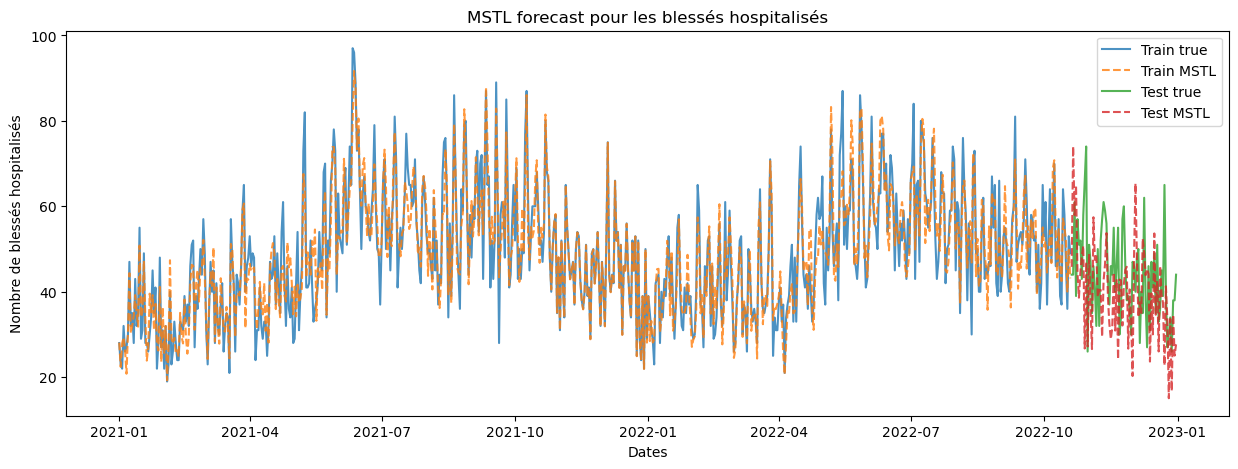

In [98]:
plt.figure(figsize = (15, 5))
plt.plot(values['ds'], values['y'], alpha = 0.8, label = 'Train true')
plt.plot(values['ds'], values['MSTL'], alpha = 0.8, label = 'Train MSTL', linestyle = "dashed")
plt.plot(Y_test_pred1['ds'], Y_test_pred1['y'], alpha = 0.8, label = 'Test true')
plt.plot(Y_test_pred1['ds'], Y_test_pred1['MSTL'], alpha = 0.8, label = 'Test MSTL', linestyle = "dashed")
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés hospitalisés')
plt.title("MSTL forecast pour les blessés hospitalisés")
plt.show()

In [99]:
fcast = sf.forecast(h=horizon, level=[95])
fcast

ds       MSTL  MSTL-lo-95  MSTL-hi-95
unique_id                                              
1         2022-10-20  45.828106   40.948753   50.707458
1         2022-10-21  74.048714   67.425415   80.672005
1         2022-10-22  57.983189   54.583401   61.382977
1         2022-10-23  64.961197   56.068798   73.853600
1         2022-10-24  44.473091   26.358301   62.587879
...              ...        ...         ...         ...
1         2022-12-27  33.642349   27.766405   39.518291
1         2022-12-28  16.775867    5.846844   27.704893
1         2022-12-29  34.646488   23.579813   45.713161
1         2022-12-30  25.059538   11.487551   38.631523
1         2022-12-31  27.685163   20.456312   34.914013

[73 rows x 4 columns]

Text(0.5, 1.0, 'Agrandissement de la partie droite de MSTL forecast pour les blessés hospitalisés')

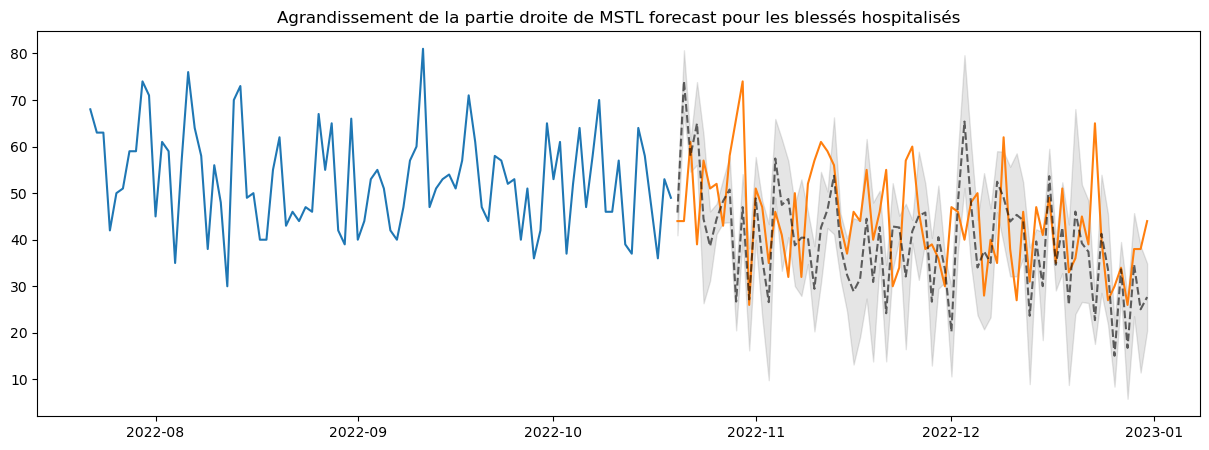

In [100]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(values['ds'][-90 :], values['y'][-90 :], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(fcast['ds'], fcast['MSTL'], "k--",label = 'Test MSTL', alpha = 0.6)
ax.fill_between(fcast['ds'], fcast['MSTL-lo-95'], fcast['MSTL-hi-95'], color='k', alpha=0.1)
ax.set_title("Agrandissement de la partie droite de MSTL forecast pour les blessés hospitalisés")

• Evaluation du modèle

In [101]:
train_predictions = values['MSTL']
test_predictions = Y_test_pred1['MSTL']

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['y'], train_predictions)
train_mse = mean_squared_error(train['y'], train_predictions)
train_rmse = mean_squared_error(train['y'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['y'], test_predictions)
test_mse = mean_squared_error(test['y'], test_predictions)
test_rmse = mean_squared_error(test['y'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                 4.361578         11.227532
1      MSE                33.016620        209.579257
2     RMSE                 5.746009         14.476852


• Prédiction pour les 6 premiers mois de 2023

Réentraînement du modèle sur tout le jeu de données

In [102]:
sf.fit(df = df_bh2)

StatsForecast(models=[MSTL])

Prédiction pour les 6 prochains mois

In [103]:
horizon = 181

In [104]:
Y_pred = sf.forecast(horizon, fitted=True)
Y_pred

ds       MSTL
unique_id                      
1         2023-01-01  30.620962
1         2023-01-02  34.838223
1         2023-01-03  21.657869
1         2023-01-04  29.704571
1         2023-01-05  38.023186
...              ...        ...
1         2023-06-26  58.277187
1         2023-06-27  40.386322
1         2023-06-28  50.554245
1         2023-06-29  56.437698
1         2023-06-30  73.425133

[181 rows x 2 columns]

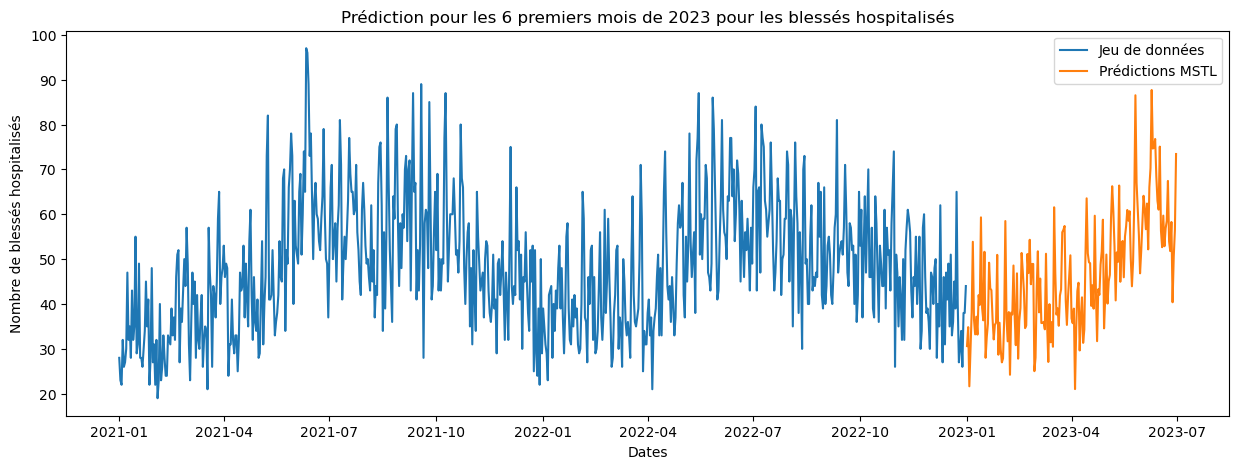

In [105]:
plt.figure(figsize = (15, 5))
plt.plot(df_bh2['ds'], df_bh2['y'], label = 'Jeu de données')
plt.plot(Y_pred['ds'], Y_pred['MSTL'], label = 'Prédictions MSTL')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés hospitalisés')
plt.title("Prédiction pour les 6 premiers mois de 2023 pour les blessés hospitalisés")
plt.show()

# Entraînement et évaluation d'un modèle PROPHET

### PROPHET + saisonnalité hebdomadaire et annuelle

In [106]:
my_model = Prophet(seasonality_mode = 'additive',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = False)

In [107]:
my_model.fit(train)

14:52:52 - cmdstanpy - INFO - Chain [1] start processing


14:52:52 - cmdstanpy - INFO - Chain [1] done processing


In [108]:
joblib.dump(my_model, "../../../data/saved_models/Blesses_hospitalises_PROPHET_train.joblib")

['../../../data/saved_models/Blesses_hospitalises_PROPHET_train.joblib']

In [109]:
test_dates = my_model.make_future_dataframe(periods = len(test), freq = 'D')
test_dates

ds
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
725 2022-12-27
726 2022-12-28
727 2022-12-29
728 2022-12-30
729 2022-12-31

[730 rows x 1 columns]

In [110]:
forecast = my_model.predict(test_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2021-01-01  33.873142   21.314313   45.676206
1 2021-01-02  38.150910   26.574322   49.318915
2 2021-01-03  32.851688   20.732045   44.084112
3 2021-01-04  22.429407   11.033037   34.881795
4 2021-01-05  25.836876   13.640731   37.813460

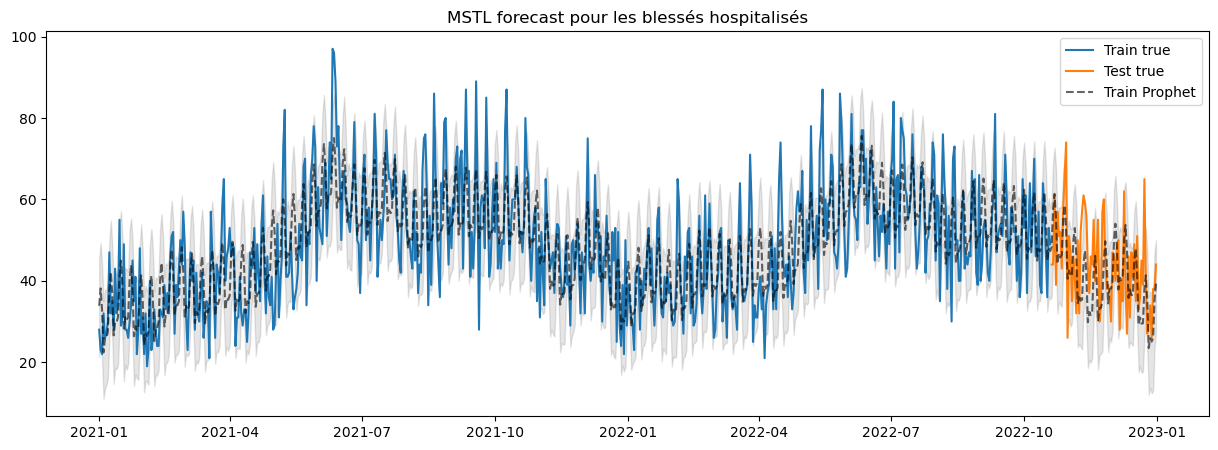

In [111]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], train['y'], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(forecast['ds'], forecast['yhat'], "k--",label = 'Train Prophet', alpha = 0.6)
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='k', alpha=0.1)
ax.set_title("MSTL forecast pour les blessés hospitalisés")
plt.legend()
plt.show()

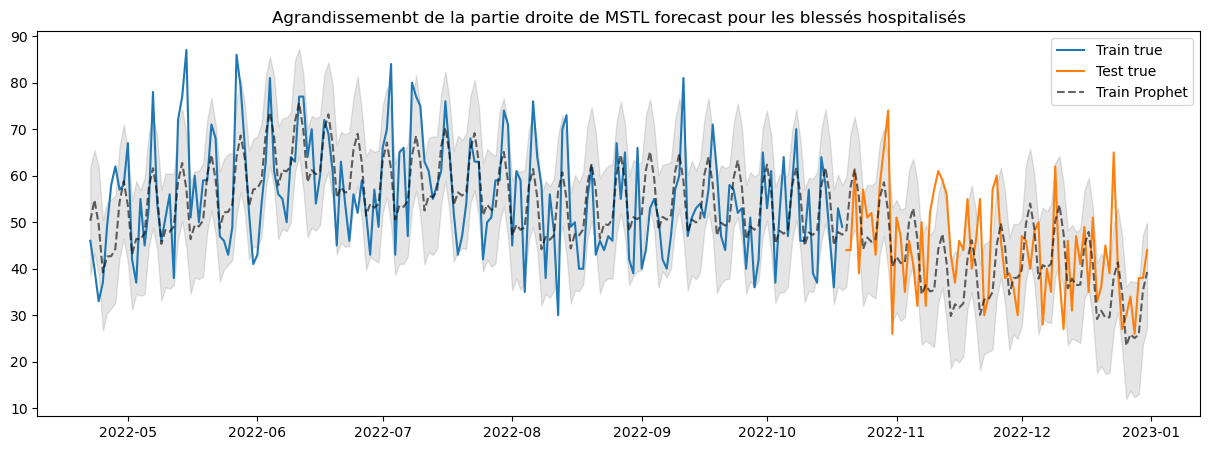

In [112]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'][-181 :], train['y'][-181 :], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(forecast['ds'][-(181 + len(test)) :], forecast['yhat'][-(181 + len(test)) :], "k--",label = 'Train Prophet', alpha = 0.6)
ax.fill_between(forecast['ds'][-(181 + len(test)) :], forecast['yhat_lower'][-(181 + len(test)) :], forecast['yhat_upper'][-(181 + len(test)) :], color='k', alpha=0.1)
ax.set_title("Agrandissemenbt de la partie droite de MSTL forecast pour les blessés hospitalisés")
plt.legend()
plt.show()

• Evaluation du modèle

In [113]:
train_predictions = forecast['yhat'][ : len(train)]
test_predictions = forecast['yhat'][len(train) : ]

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['y'], train_predictions)
train_mse = mean_squared_error(train['y'], train_predictions)
train_rmse = mean_squared_error(train['y'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['y'], test_predictions)
test_mse = mean_squared_error(test['y'], test_predictions)
test_rmse = mean_squared_error(test['y'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                 7.390105          9.417692
1      MSE                86.424098        127.083360
2     RMSE                 9.296456         11.273126


• Prédiction pour les 6 premiers mois de 2023

Réentraînement du modèle sur tout le jeu de données

In [114]:
my_model = Prophet(seasonality_mode = 'additive',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = False)

In [115]:
my_model.fit(df_bh2)

14:52:53 - cmdstanpy - INFO - Chain [1] start processing


14:52:53 - cmdstanpy - INFO - Chain [1] done processing


In [116]:
joblib.dump(my_model, "../../../data/saved_models/Blesses_hospitalises_PROPHET_df.joblib")

['../../../data/saved_models/Blesses_hospitalises_PROPHET_df.joblib']

Prédiction pour les 6 prochains mois

In [117]:
futur_dates = my_model.make_future_dataframe(periods = 181, freq = 'D')
futur_dates

ds
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
906 2023-06-26
907 2023-06-27
908 2023-06-28
909 2023-06-29
910 2023-06-30

[911 rows x 1 columns]

In [118]:
forecast = my_model.predict(futur_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2021-01-01  36.626595   24.617896   48.902155
1 2021-01-02  39.616105   27.301626   51.800273
2 2021-01-03  34.393676   22.233841   47.484820
3 2021-01-04  24.733283   12.613960   37.307710
4 2021-01-05  27.048101   15.076901   38.640663

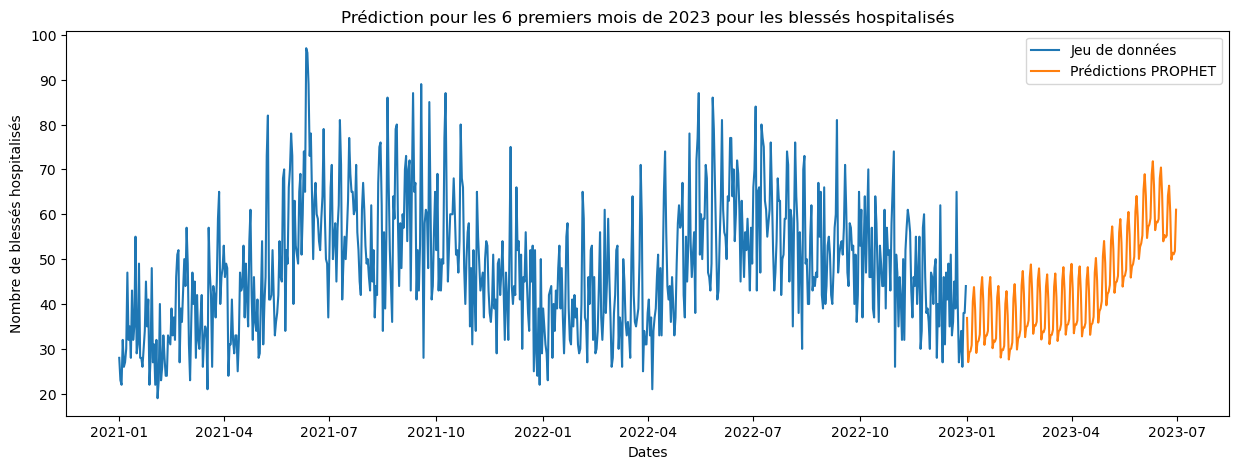

In [119]:
plt.figure(figsize = (15, 5))
plt.plot(df_bh2['ds'], df_bh2['y'], label = 'Jeu de données')
plt.plot(forecast['ds'][-181 : ], forecast['yhat'][-181 : ], label = 'Prédictions PROPHET')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés hospitalisés')
plt.title("Prédiction pour les 6 premiers mois de 2023 pour les blessés hospitalisés")
plt.show()

### PROPHET + ajout des vacances scolaires communes

In [120]:
# Vacances scolaires
vac = pd.read_csv(conf['local_data_path'] + "vacances_scolaires.csv",sep = ";")
vac['jour'] = vac['date'].apply(lambda x : x.split("/")[0])
vac['mois'] = vac['date'].apply(lambda x : x.split("/")[1])
vac['an'] = vac['date'].apply(lambda x : x.split("/")[2])
vac

date  vacances_zone_a  vacances_zone_b  vacances_zone_c  \
0      01/01/1990            False            False            False   
1      02/01/1990            False            False            False   
2      03/01/1990            False            False            False   
3      04/01/1990            False            False            False   
4      05/01/1990            False            False            False   
...           ...              ...              ...              ...   
13509  27/12/2026            False            False            False   
13510  28/12/2026            False            False            False   
13511  29/12/2026            False            False            False   
13512  30/12/2026            False            False            False   
13513  31/12/2026            False            False            False   

      nom_vacances jour mois    an  
0              NaN   01   01  1990  
1              NaN   02   01  1990  
2              NaN   03   01  1990  
3              NaN   04   01  1990  
4              NaN   05   01  1990  
...            ...  ...  ...   ...  
13509          NaN   27   12  2026  
13510          NaN   28   12  2026  
13511          NaN   29   12  2026  
13512          NaN   30   12  2026  
13513          NaN   31   12  2026  

[13514 rows x 8 columns]

In [121]:
y_m_j = vac['an'].astype('str') + "-" + vac['mois'].astype('str') + "-" + vac['jour'].astype('str')
vac.insert(loc = 0, column = 'y_m_j', value = y_m_j)
vac = vac.drop(['date', 'an', 'mois', 'jour'], axis = 1)
vac.head()

y_m_j  vacances_zone_a  vacances_zone_b  vacances_zone_c nom_vacances
0  1990-01-01            False            False            False          NaN
1  1990-01-02            False            False            False          NaN
2  1990-01-03            False            False            False          NaN
3  1990-01-04            False            False            False          NaN
4  1990-01-05            False            False            False          NaN

In [122]:
vac = vac.loc[(vac['vacances_zone_a'] == True) & (vac['vacances_zone_b'] == True) & (vac['vacances_zone_c'] == True)]
#vac = vac.drop(['vacances_zone_a', 'vacances_zone_b', 'vacances_zone_c', 'nom_vacances'], axis = 1)
vac

y_m_j  vacances_zone_a  vacances_zone_b  vacances_zone_c  \
299    1990-10-27             True             True             True   
300    1990-10-28             True             True             True   
301    1990-10-29             True             True             True   
302    1990-10-30             True             True             True   
303    1990-10-31             True             True             True   
...           ...              ...              ...              ...   
13386  2026-08-26             True             True             True   
13387  2026-08-27             True             True             True   
13388  2026-08-28             True             True             True   
13389  2026-08-29             True             True             True   
13390  2026-08-30             True             True             True   

                   nom_vacances  
299    Vacances de la Toussaint  
300    Vacances de la Toussaint  
301    Vacances de la Toussaint  
302    Vacances de la Toussaint  
303    Vacances de la Toussaint  
...                         ...  
13386            Vacances d'‚t‚  
13387            Vacances d'‚t‚  
13388            Vacances d'‚t‚  
13389            Vacances d'‚t‚  
13390            Vacances d'‚t‚  

[3440 rows x 5 columns]

In [123]:
vac = vac[(vac['y_m_j'] >= '2021-01-01') & (vac['y_m_j'] < '2023-07-01')]
vac

y_m_j  vacances_zone_a  vacances_zone_b  vacances_zone_c  \
11323  2021-01-01             True             True             True   
11324  2021-01-02             True             True             True   
11325  2021-01-03             True             True             True   
11373  2021-02-20             True             True             True   
11374  2021-02-21             True             True             True   
...           ...              ...              ...              ...   
12054  2023-01-02             True             True             True   
12101  2023-02-18             True             True             True   
12102  2023-02-19             True             True             True   
12164  2023-04-22             True             True             True   
12165  2023-04-23             True             True             True   

                nom_vacances  
11323       Vacances de No‰l  
11324       Vacances de No‰l  
11325       Vacances de No‰l  
11373       Vacances d'hiver  
11374       Vacances d'hiver  
...                      ...  
12054       Vacances de No‰l  
12101       Vacances d'hiver  
12102       Vacances d'hiver  
12164  Vacances de printemps  
12165  Vacances de printemps  

[202 rows x 5 columns]

In [124]:
vac = vac.set_index(vac['y_m_j'])
vac

y_m_j  vacances_zone_a  vacances_zone_b  vacances_zone_c  \
y_m_j                                                                       
2021-01-01  2021-01-01             True             True             True   
2021-01-02  2021-01-02             True             True             True   
2021-01-03  2021-01-03             True             True             True   
2021-02-20  2021-02-20             True             True             True   
2021-02-21  2021-02-21             True             True             True   
...                ...              ...              ...              ...   
2023-01-02  2023-01-02             True             True             True   
2023-02-18  2023-02-18             True             True             True   
2023-02-19  2023-02-19             True             True             True   
2023-04-22  2023-04-22             True             True             True   
2023-04-23  2023-04-23             True             True             True   

                     nom_vacances  
y_m_j                              
2021-01-01       Vacances de No‰l  
2021-01-02       Vacances de No‰l  
2021-01-03       Vacances de No‰l  
2021-02-20       Vacances d'hiver  
2021-02-21       Vacances d'hiver  
...                           ...  
2023-01-02       Vacances de No‰l  
2023-02-18       Vacances d'hiver  
2023-02-19       Vacances d'hiver  
2023-04-22  Vacances de printemps  
2023-04-23  Vacances de printemps  

[202 rows x 5 columns]

In [125]:
vac_date = []
for i in range(len(vac)):
    vac_date.append(vac.index[i])
    
vac_date

['2021-01-01',
 '2021-01-02',
 '2021-01-03',
 '2021-02-20',
 '2021-02-21',
 '2021-04-24',
 '2021-04-25',
 '2021-05-13',
 '2021-05-14',
 '2021-05-15',
 '2021-05-16',
 '2021-05-17',
 '2021-07-06',
 '2021-07-07',
 '2021-07-08',
 '2021-07-09',
 '2021-07-10',
 '2021-07-11',
 '2021-07-12',
 '2021-07-13',
 '2021-07-14',
 '2021-07-15',
 '2021-07-16',
 '2021-07-17',
 '2021-07-18',
 '2021-07-19',
 '2021-07-20',
 '2021-07-21',
 '2021-07-22',
 '2021-07-23',
 '2021-07-24',
 '2021-07-25',
 '2021-07-26',
 '2021-07-27',
 '2021-07-28',
 '2021-07-29',
 '2021-07-30',
 '2021-07-31',
 '2021-08-01',
 '2021-08-02',
 '2021-08-03',
 '2021-08-04',
 '2021-08-05',
 '2021-08-06',
 '2021-08-07',
 '2021-08-08',
 '2021-08-09',
 '2021-08-10',
 '2021-08-11',
 '2021-08-12',
 '2021-08-13',
 '2021-08-14',
 '2021-08-15',
 '2021-08-16',
 '2021-08-17',
 '2021-08-18',
 '2021-08-19',
 '2021-08-20',
 '2021-08-21',
 '2021-08-22',
 '2021-08-23',
 '2021-08-24',
 '2021-08-25',
 '2021-08-26',
 '2021-08-27',
 '2021-08-28',
 '2021-08-

In [126]:
vacances = pd.DataFrame({'holiday' : 'vacances',
                        'ds' : pd.to_datetime(vac_date)})

vacances

holiday         ds
0    vacances 2021-01-01
1    vacances 2021-01-02
2    vacances 2021-01-03
3    vacances 2021-02-20
4    vacances 2021-02-21
..        ...        ...
197  vacances 2023-01-02
198  vacances 2023-02-18
199  vacances 2023-02-19
200  vacances 2023-04-22
201  vacances 2023-04-23

[202 rows x 2 columns]

In [127]:
my_model = Prophet(seasonality_mode = 'additive',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = False,
                   holidays = vacances)

In [128]:
my_model.fit(train)

14:52:54 - cmdstanpy - INFO - Chain [1] start processing
14:52:54 - cmdstanpy - INFO - Chain [1] done processing


In [129]:
joblib.dump(my_model, "../../../data/saved_models/Blesses_hospitalises_PROPHET_vacances_train.joblib")

['../../../data/saved_models/Blesses_hospitalises_PROPHET_vacances_train.joblib']

In [130]:
test_dates = my_model.make_future_dataframe(periods = len(test), freq = 'D')
test_dates

ds
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
725 2022-12-27
726 2022-12-28
727 2022-12-29
728 2022-12-30
729 2022-12-31

[730 rows x 1 columns]

In [131]:
forecast = my_model.predict(test_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2021-01-01  32.411038   20.652238   44.253475
1 2021-01-02  36.752835   25.541366   48.546676
2 2021-01-03  31.309196   18.880865   43.030046
3 2021-01-04  23.684199   12.496118   34.287483
4 2021-01-05  26.944562   14.572413   37.795969

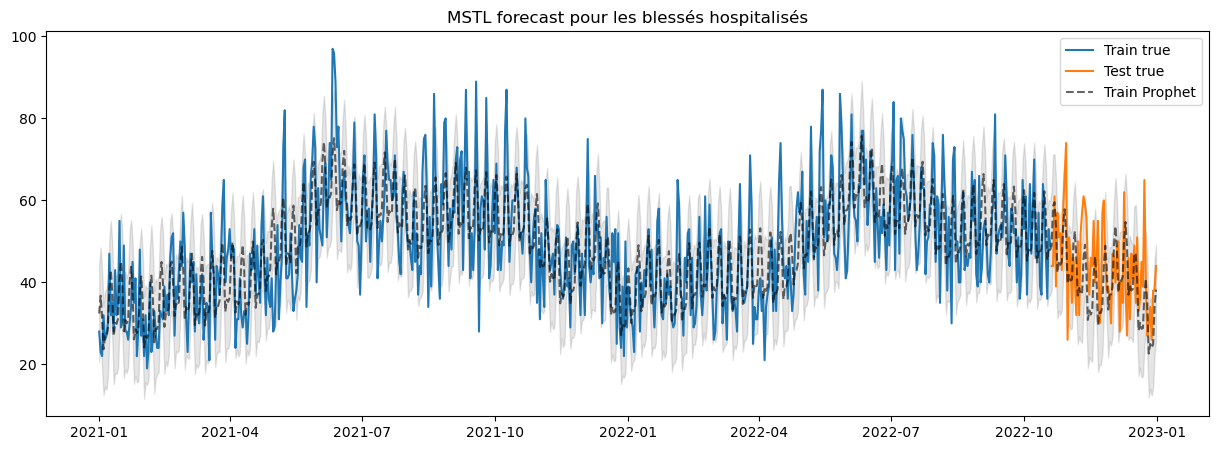

In [132]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], train['y'], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(forecast['ds'], forecast['yhat'], "k--",label = 'Train Prophet', alpha = 0.6)
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='k', alpha=0.1)
ax.set_title("MSTL forecast pour les blessés hospitalisés")
plt.legend()
plt.show()

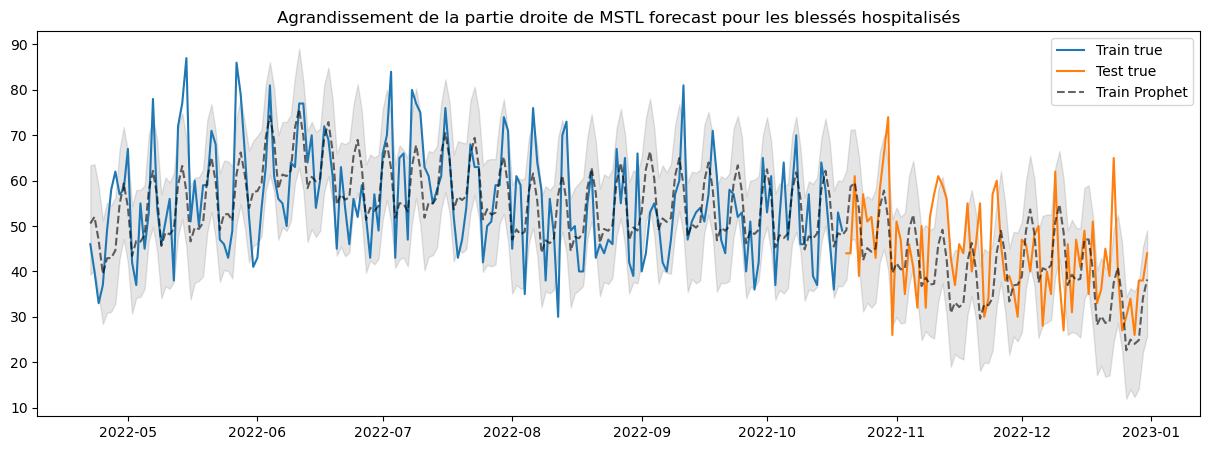

In [133]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'][-181 :], train['y'][-181 :], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(forecast['ds'][-(181 + len(test)) :], forecast['yhat'][-(181 + len(test)) :], "k--",label = 'Train Prophet', alpha = 0.6)
ax.fill_between(forecast['ds'][-(181 + len(test)) :], forecast['yhat_lower'][-(181 + len(test)) :], forecast['yhat_upper'][-(181 + len(test)) :], color='k', alpha=0.1)
ax.set_title("Agrandissement de la partie droite de MSTL forecast pour les blessés hospitalisés")
plt.legend()
plt.show()

• Evaluation du modèle

In [134]:
train_predictions = forecast['yhat'][ : len(train)]
test_predictions = forecast['yhat'][len(train) : ]

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['y'], train_predictions)
train_mse = mean_squared_error(train['y'], train_predictions)
train_rmse = mean_squared_error(train['y'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['y'], test_predictions)
test_mse = mean_squared_error(test['y'], test_predictions)
test_rmse = mean_squared_error(test['y'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                 7.348420          9.412157
1      MSE                85.913095        126.288259
2     RMSE                 9.268932         11.237805


• Prédiction pour les 6 premiers mois de 2023

Réentraînement du modèle sur tout le jeu de données

In [135]:
my_model = Prophet(seasonality_mode = 'additive',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = False,
                   holidays = vacances)

In [136]:
my_model.fit(df_bh2)

14:52:54 - cmdstanpy - INFO - Chain [1] start processing
14:52:54 - cmdstanpy - INFO - Chain [1] done processing


In [137]:
joblib.dump(my_model, "../../../data/saved_models/Blesses_hospitalises_PROPHET_vacances_df.joblib")

['../../../data/saved_models/Blesses_hospitalises_PROPHET_vacances_df.joblib']

In [138]:
futur_dates = my_model.make_future_dataframe(periods = 181, freq = 'D')
futur_dates

ds
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
906 2023-06-26
907 2023-06-27
908 2023-06-28
909 2023-06-29
910 2023-06-30

[911 rows x 1 columns]

In [139]:
forecast = my_model.predict(futur_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2021-01-01  35.411495   24.011453   47.006631
1 2021-01-02  38.509879   26.788507   49.557762
2 2021-01-03  33.154040   20.994693   44.384238
3 2021-01-04  26.073662   15.167004   39.282704
4 2021-01-05  28.254260   15.747312   40.394677

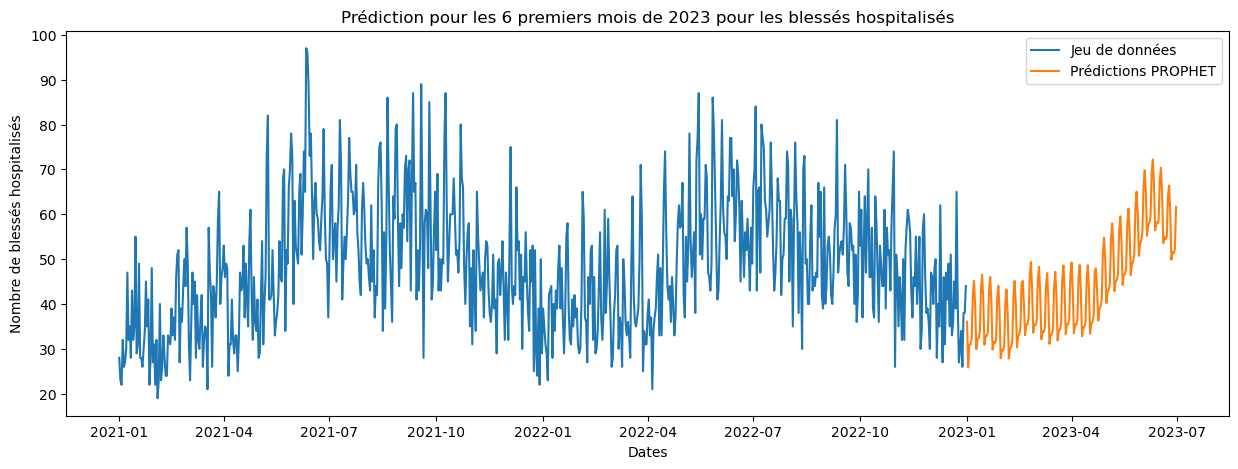

In [140]:
plt.figure(figsize = (15, 5))
plt.plot(df_bh2['ds'], df_bh2['y'], label = 'Jeu de données')
plt.plot(forecast['ds'][-181 : ], forecast['yhat'][-181 : ], label = 'Prédictions PROPHET')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés hospitalisés')
plt.title("Prédiction pour les 6 premiers mois de 2023 pour les blessés hospitalisés")
plt.show()

### PROPHET + ajout des jours fériés communs

In [141]:
#Lecture du fichier des jours fériés
feries = pd.read_csv(conf['local_data_path'] +"jours_feries.csv", sep = ",", low_memory=False)

feries

date            nom_jour_ferie  \
0    2004-01-01               1er janvier   
1    2004-04-09            Vendredi saint   
2    2004-04-12           Lundi de Pâques   
3    2004-04-27  Abolition de l'esclavage   
4    2004-05-01                   1er mai   
..          ...                       ...   
501  2029-11-01                 Toussaint   
502  2029-11-11               11 novembre   
503  2029-12-20  Abolition de l'esclavage   
504  2029-12-25              Jour de Noël   
505  2029-12-26         2ème jour de Noël   

                                                 zones  
0    Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
1                                       Alsace-Moselle  
2    Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
3                                              Mayotte  
4    Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
..                                                 ...  
501  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
502  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
503                                         La Réunion  
504  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
505                                     Alsace-Moselle  

[506 rows x 3 columns]

In [142]:
feries = feries[(feries['date'] >= '2021-01-01') & (feries['date'] < '2023-07-01')]
feries

date            nom_jour_ferie  \
326  2021-01-01               1er janvier   
327  2021-04-02            Vendredi saint   
328  2021-04-05           Lundi de Pâques   
329  2021-04-27  Abolition de l'esclavage   
330  2021-05-01                   1er mai   
331  2021-05-08                     8 mai   
332  2021-05-13                 Ascension   
333  2021-05-22  Abolition de l'esclavage   
334  2021-05-24        Lundi de Pentecôte   
335  2021-05-27  Abolition de l'esclavage   
336  2021-05-28  Abolition de l'esclavage   
337  2021-06-10  Abolition de l'esclavage   
338  2021-07-14                14 juillet   
339  2021-08-15                Assomption   
340  2021-10-09  Abolition de l'esclavage   
341  2021-11-01                 Toussaint   
342  2021-11-11               11 novembre   
343  2021-12-20  Abolition de l'esclavage   
344  2021-12-25              Jour de Noël   
345  2021-12-26         2ème jour de Noël   
346  2022-01-01               1er janvier   
347  2022-04-15            Vendredi saint   
348  2022-04-18           Lundi de Pâques   
349  2022-04-27  Abolition de l'esclavage   
350  2022-05-01                   1er mai   
351  2022-05-08                     8 mai   
352  2022-05-22  Abolition de l'esclavage   
353  2022-05-26                 Ascension   
354  2022-05-27  Abolition de l'esclavage   
355  2022-05-28  Abolition de l'esclavage   
356  2022-06-06        Lundi de Pentecôte   
357  2022-06-10  Abolition de l'esclavage   
358  2022-07-14                14 juillet   
359  2022-08-15                Assomption   
360  2022-10-09  Abolition de l'esclavage   
361  2022-11-01                 Toussaint   
362  2022-11-11               11 novembre   
363  2022-12-20  Abolition de l'esclavage   
364  2022-12-25              Jour de Noël   
365  2022-12-26         2ème jour de Noël   
366  2023-01-01               1er janvier   
367  2023-04-07            Vendredi saint   
368  2023-04-10           Lundi de Pâques   
369  2023-04-27  Abolition de l'esclavage   
370  2023-05-01                   1er mai   
371  2023-05-08                     8 mai   
372  2023-05-18                 Ascension   
373  2023-05-22  Abolition de l'esclavage   
374  2023-05-27  Abolition de l'esclavage   
375  2023-05-28  Abolition de l'esclavage   
376  2023-05-29        Lundi de Pentecôte   
377  2023-06-10  Abolition de l'esclavage   

                                                 zones  
326  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
327                                     Alsace-Moselle  
328  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
329                                            Mayotte  
330  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
331  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
332  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
333                                         Martinique  
334  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
335                                         Guadeloupe  
336                                       Saint-Martin  
337                                             Guyane  
338  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
339  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
340                                   Saint-Barthélémy  
341  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
342  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
343                                         La Réunion  
344  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
345                                     Alsace-Moselle  
346  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
347                                     Alsace-Moselle  
348  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
349                                            Mayotte  
350  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
351  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
352                                         Martinique  
353  Métropole|Alsace-Moselle

In [143]:
feries['nom_jour_ferie'].unique

<bound method Series.unique of 326                 1er janvier
327              Vendredi saint
328             Lundi de Pâques
329    Abolition de l'esclavage
330                     1er mai
331                       8 mai
332                   Ascension
333    Abolition de l'esclavage
334          Lundi de Pentecôte
335    Abolition de l'esclavage
336    Abolition de l'esclavage
337    Abolition de l'esclavage
338                  14 juillet
339                  Assomption
340    Abolition de l'esclavage
341                   Toussaint
342                 11 novembre
343    Abolition de l'esclavage
344                Jour de Noël
345           2ème jour de Noël
346                 1er janvier
347              Vendredi saint
348             Lundi de Pâques
349    Abolition de l'esclavage
350                     1er mai
351                       8 mai
352    Abolition de l'esclavage
353                   Ascension
354    Abolition de l'esclavage
355    Abolition de l'esclavage
356      

In [144]:
for index, item in zip(feries.index, feries['nom_jour_ferie']) :
    if item == "Abolition de l'esclavage":
        feries = feries.drop(index)

In [145]:
for index, item in zip(feries.index, feries['nom_jour_ferie']) :
    if item == "Vendredi saint":
        feries = feries.drop(index)

In [146]:
for index, item in zip(feries.index, feries['nom_jour_ferie']) :
    if item == "2ème jour de Noël":
        feries = feries.drop(index)

In [147]:
feries = feries.set_index(feries['date'])
feries

date      nom_jour_ferie  \
date                                         
2021-01-01  2021-01-01         1er janvier   
2021-04-05  2021-04-05     Lundi de Pâques   
2021-05-01  2021-05-01             1er mai   
2021-05-08  2021-05-08               8 mai   
2021-05-13  2021-05-13           Ascension   
2021-05-24  2021-05-24  Lundi de Pentecôte   
2021-07-14  2021-07-14          14 juillet   
2021-08-15  2021-08-15          Assomption   
2021-11-01  2021-11-01           Toussaint   
2021-11-11  2021-11-11         11 novembre   
2021-12-25  2021-12-25        Jour de Noël   
2022-01-01  2022-01-01         1er janvier   
2022-04-18  2022-04-18     Lundi de Pâques   
2022-05-01  2022-05-01             1er mai   
2022-05-08  2022-05-08               8 mai   
2022-05-26  2022-05-26           Ascension   
2022-06-06  2022-06-06  Lundi de Pentecôte   
2022-07-14  2022-07-14          14 juillet   
2022-08-15  2022-08-15          Assomption   
2022-11-01  2022-11-01           Toussaint   
2022-11-11  2022-11-11         11 novembre   
2022-12-25  2022-12-25        Jour de Noël   
2023-01-01  2023-01-01         1er janvier   
2023-04-10  2023-04-10     Lundi de Pâques   
2023-05-01  2023-05-01             1er mai   
2023-05-08  2023-05-08               8 mai   
2023-05-18  2023-05-18           Ascension   
2023-05-29  2023-05-29  Lundi de Pentecôte   

                                                        zones  
date                                                           
2021-01-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-04-05  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-05-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-05-08  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-05-13  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-05-24  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-07-14  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-08-15  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-11-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-11-11  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2021-12-25  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-01-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-04-18  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-05-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-05-08  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-05-26  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-06-06  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-07-14  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-08-15  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-11-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-11-11  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2022-12-25  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2023-01-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2023-04-10  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2023-05-01  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2023-05-08  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2023-05-18  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...  
2023-05-29  Métropole|Alsace-Moselle|Guadeloupe|Guyane|Mar...

In [148]:
feries_date = []
for i in range(len(feries)):
    feries_date.append(feries.index[i])
    
feries_date

['2021-01-01',
 '2021-04-05',
 '2021-05-01',
 '2021-05-08',
 '2021-05-13',
 '2021-05-24',
 '2021-07-14',
 '2021-08-15',
 '2021-11-01',
 '2021-11-11',
 '2021-12-25',
 '2022-01-01',
 '2022-04-18',
 '2022-05-01',
 '2022-05-08',
 '2022-05-26',
 '2022-06-06',
 '2022-07-14',
 '2022-08-15',
 '2022-11-01',
 '2022-11-11',
 '2022-12-25',
 '2023-01-01',
 '2023-04-10',
 '2023-05-01',
 '2023-05-08',
 '2023-05-18',
 '2023-05-29']

In [149]:
jours_feries = pd.DataFrame({'holiday' : 'feries',
                            'ds' : pd.to_datetime(feries_date)})

jours_feries

holiday         ds
0   feries 2021-01-01
1   feries 2021-04-05
2   feries 2021-05-01
3   feries 2021-05-08
4   feries 2021-05-13
5   feries 2021-05-24
6   feries 2021-07-14
7   feries 2021-08-15
8   feries 2021-11-01
9   feries 2021-11-11
10  feries 2021-12-25
11  feries 2022-01-01
12  feries 2022-04-18
13  feries 2022-05-01
14  feries 2022-05-08
15  feries 2022-05-26
16  feries 2022-06-06
17  feries 2022-07-14
18  feries 2022-08-15
19  feries 2022-11-01
20  feries 2022-11-11
21  feries 2022-12-25
22  feries 2023-01-01
23  feries 2023-04-10
24  feries 2023-05-01
25  feries 2023-05-08
26  feries 2023-05-18
27  feries 2023-05-29

In [150]:
my_model = Prophet(seasonality_mode = 'additive',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = False,
                   holidays = jours_feries)

In [151]:
my_model.fit(train)

14:52:55 - cmdstanpy - INFO - Chain [1] start processing
14:52:55 - cmdstanpy - INFO - Chain [1] done processing


In [152]:
joblib.dump(my_model, "../../../data/saved_models/Blesses_hospitalises_PROPHET_feries_train.joblib")

['../../../data/saved_models/Blesses_hospitalises_PROPHET_feries_train.joblib']

In [153]:
test_dates = my_model.make_future_dataframe(periods = len(test), freq = 'D')
test_dates

ds
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
725 2022-12-27
726 2022-12-28
727 2022-12-29
728 2022-12-30
729 2022-12-31

[730 rows x 1 columns]

In [154]:
forecast = my_model.predict(test_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2021-01-01  32.001259   19.149150   43.185439
1 2021-01-02  38.415328   26.240531   49.792815
2 2021-01-03  33.080801   21.761235   45.400618
3 2021-01-04  22.710805   12.105742   35.511341
4 2021-01-05  25.969715   14.390440   38.237141

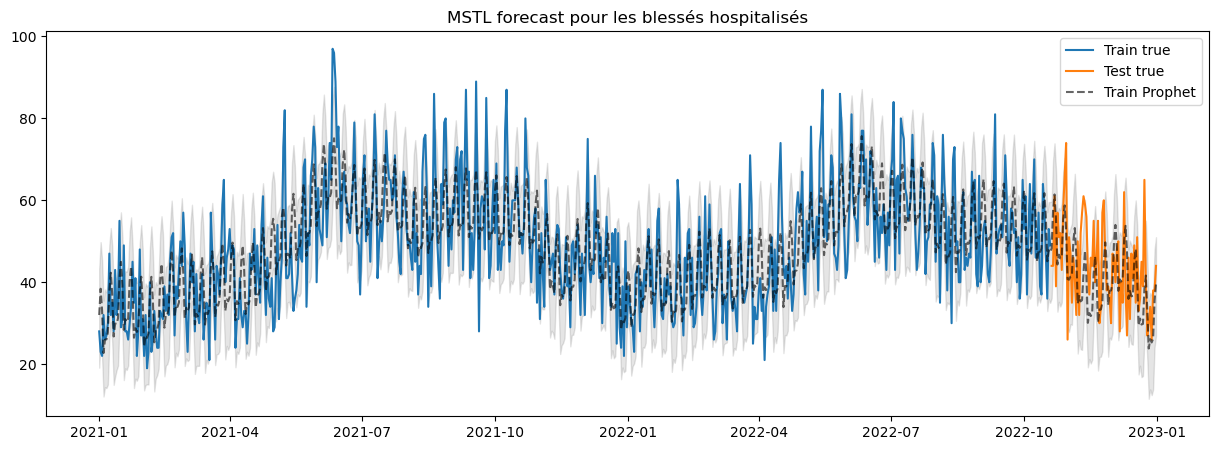

In [155]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], train['y'], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(forecast['ds'], forecast['yhat'], "k--",label = 'Train Prophet', alpha = 0.6)
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='k', alpha=0.1)
ax.set_title("MSTL forecast pour les blessés hospitalisés")
plt.legend()
plt.show()

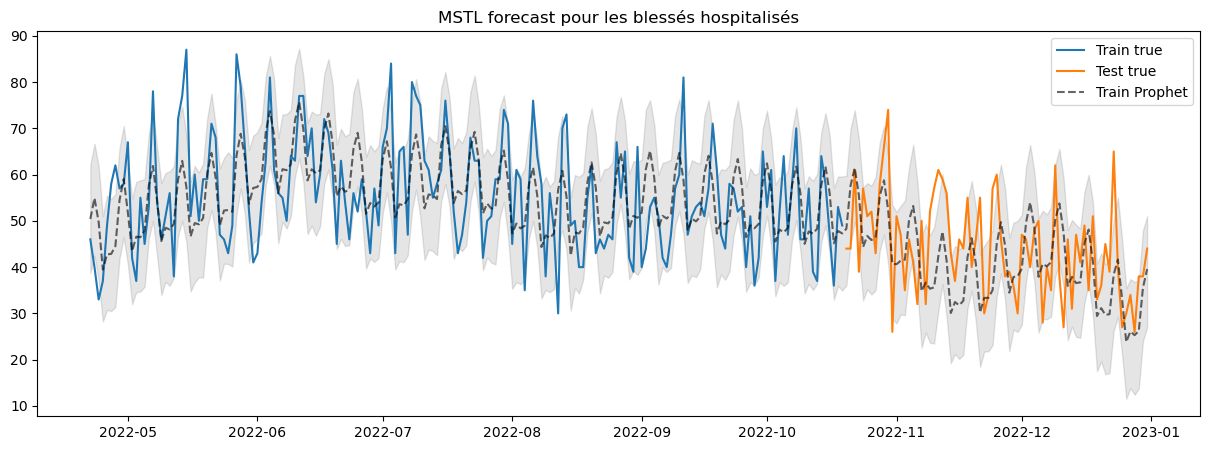

In [156]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'][-181 :], train['y'][-181 :], label = 'Train true')
ax.plot(test['ds'], test['y'], label = 'Test true')
ax.plot(forecast['ds'][-(181 + len(test)) :], forecast['yhat'][-(181 + len(test)) :], "k--",label = 'Train Prophet', alpha = 0.6)
ax.fill_between(forecast['ds'][-(181 + len(test)) :], forecast['yhat_lower'][-(181 + len(test)) :], forecast['yhat_upper'][-(181 + len(test)) :], color='k', alpha=0.1)
ax.set_title("MSTL forecast pour les blessés hospitalisés")
plt.legend()
plt.show()

• Evaluation du modèle

In [157]:
train_predictions = forecast['yhat'][ : len(train)]
test_predictions = forecast['yhat'][len(train) : ]

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train['y'], train_predictions)
train_mse = mean_squared_error(train['y'], train_predictions)
train_rmse = mean_squared_error(train['y'], train_predictions, squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test['y'], test_predictions)
test_mse = mean_squared_error(test['y'], test_predictions)
test_rmse = mean_squared_error(test['y'], test_predictions, squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                 7.381595          9.386292
1      MSE                86.325400        126.837743
2     RMSE                 9.291146         11.262226


• Prédiction pour les 6 premiers mois de 2023

Réentraînement du modèle sur tout le jeu de données

In [158]:
my_model = Prophet(seasonality_mode = 'additive',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = False)

In [159]:
my_model.fit(df_bh2)

14:52:55 - cmdstanpy - INFO - Chain [1] start processing


14:52:56 - cmdstanpy - INFO - Chain [1] done processing


In [160]:
joblib.dump(my_model, "../../../data/saved_models/Blesses_hospitalises_PROPHET_feries_df.joblib")

['../../../data/saved_models/Blesses_hospitalises_PROPHET_feries_df.joblib']

In [161]:
futur_dates = my_model.make_future_dataframe(periods = 181, freq = 'D')
futur_dates

ds
0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
..         ...
906 2023-06-26
907 2023-06-27
908 2023-06-28
909 2023-06-29
910 2023-06-30

[911 rows x 1 columns]

In [162]:
forecast = my_model.predict(futur_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2021-01-01  36.626595   24.987612   48.300633
1 2021-01-02  39.616105   26.850802   52.687716
2 2021-01-03  34.393676   22.550762   46.024675
3 2021-01-04  24.733283   12.458738   36.683770
4 2021-01-05  27.048101   14.762056   38.848422

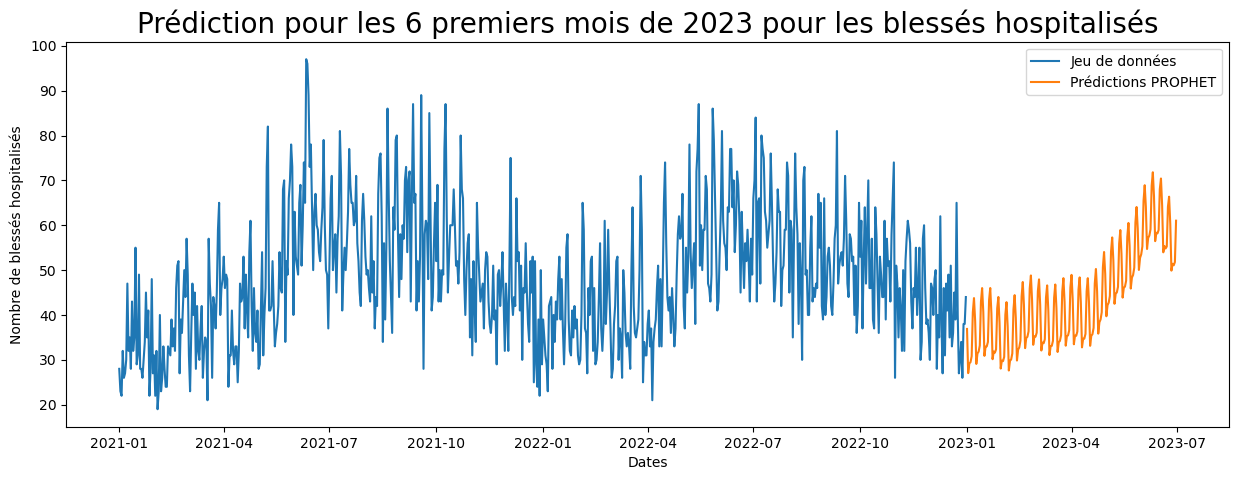

In [163]:
plt.figure(figsize = (15, 5))
plt.plot(df_bh2['ds'], df_bh2['y'], label = 'Jeu de données')
plt.plot(forecast['ds'][-181 : ], forecast['yhat'][-181 : ], label = 'Prédictions PROPHET')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés hospitalisés')
plt.title("Prédiction pour les 6 premiers mois de 2023 pour les blessés hospitalisés", {'fontsize' : 20})
plt.show()

# Entraînement et évaluation d'un modèle LSTM

### Vanilla LSTM

Préparation du jeu de données

En s'aidant de https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [164]:
dataset = df2.values
dataset

array([[28],
       [23],
       [22],
       [32],
       [26],
       [27],
       [30],
       [47],
       [32],
       [35],
       [28],
       [43],
       [32],
       [35],
       [55],
       [29],
       [31],
       [49],
       [28],
       [28],
       [26],
       [30],
       [34],
       [45],
       [35],
       [41],
       [22],
       [28],
       [48],
       [27],
       [31],
       [22],
       [32],
       [19],
       [23],
       [40],
       [23],
       [26],
       [33],
       [28],
       [24],
       [24],
       [33],
       [32],
       [31],
       [39],
       [33],
       [37],
       [32],
       [46],
       [51],
       [52],
       [27],
       [39],
       [36],
       [43],
       [50],
       [44],
       [57],
       [49],
       [31],
       [23],
       [36],
       [47],
       [40],
       [45],
       [28],
       [42],
       [32],
       [30],
       [37],
       [42],
       [26],
       [32],
       [35],
       [34],
       [21],

In [165]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

In [166]:
train_scaled, test_scaled = train_test_split(dataset_scaled, test_size = 0.1, shuffle = False)
print(len(train_scaled), len(test_scaled))

657 73


In [167]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [168]:
# reshape into X=t and Y=t+1
look_back = 31
trainX_scaled, trainY_scaled = create_dataset(train_scaled, look_back)
testX_scaled, testY_scaled = create_dataset(test_scaled, look_back)

In [169]:
trainX_scaled.shape, trainY_scaled.shape

((625, 31), (625,))

In [170]:
trainX_scaled, trainY_scaled

(array([[0.11538462, 0.05128205, 0.03846154, ..., 0.37179487, 0.1025641 ,
         0.15384615],
        [0.05128205, 0.03846154, 0.16666667, ..., 0.1025641 , 0.15384615,
         0.03846154],
        [0.03846154, 0.16666667, 0.08974359, ..., 0.15384615, 0.03846154,
         0.16666667],
        ...,
        [0.44871795, 0.41025641, 0.48717949, ..., 0.23076923, 0.57692308,
         0.5       ],
        [0.41025641, 0.48717949, 0.66666667, ..., 0.57692308, 0.5       ,
         0.35897436],
        [0.48717949, 0.66666667, 0.53846154, ..., 0.5       , 0.35897436,
         0.21794872]]),
 array([0.03846154, 0.16666667, 0.        , 0.05128205, 0.26923077,
        0.05128205, 0.08974359, 0.17948718, 0.11538462, 0.06410256,
        0.06410256, 0.17948718, 0.16666667, 0.15384615, 0.25641026,
        0.17948718, 0.23076923, 0.16666667, 0.34615385, 0.41025641,
        0.42307692, 0.1025641 , 0.25641026, 0.21794872, 0.30769231,
        0.3974359 , 0.32051282, 0.48717949, 0.38461538, 0.15384615,
 

In [171]:
# reshape input to be [samples, time steps, features]
trainX_scaled= np.reshape(trainX_scaled, (trainX_scaled.shape[0], 1, trainX_scaled.shape[1]))
testX_scaled = np.reshape(testX_scaled, (testX_scaled.shape[0], 1, testX_scaled.shape[1]))

Création et entraînement du modèle

In [172]:
# On fixe un random seed pour la reporductibilité
tf.random.set_seed(7)

In [173]:
#Implémentation du modèle et entraînement
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(4),
    tf.keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX_scaled, trainY_scaled, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


625/625 - 1s - 1ms/step - loss: 0.0446
Epoch 2/100
625/625 - 0s - 366us/step - loss: 0.0204
Epoch 3/100
625/625 - 0s - 366us/step - loss: 0.0194
Epoch 4/100
625/625 - 0s - 368us/step - loss: 0.0187
Epoch 5/100
625/625 - 0s - 365us/step - loss: 0.0183
Epoch 6/100
625/625 - 0s - 371us/step - loss: 0.0179
Epoch 7/100
625/625 - 0s - 367us/step - loss: 0.0177
Epoch 8/100
625/625 - 0s - 369us/step - loss: 0.0175
Epoch 9/100
625/625 - 0s - 402us/step - loss: 0.0173
Epoch 10/100
625/625 - 0s - 370us/step - loss: 0.0171
Epoch 11/100
625/625 - 0s - 360us/step - loss: 0.0170
Epoch 12/100
625/625 - 0s - 345us/step - loss: 0.0169
Epoch 13/100
625/625 - 0s - 449us/step - loss: 0.0168
Epoch 14/100
625/625 - 0s - 349us/step - loss: 0.0167
Epoch 15/100
625/625 - 0s - 346us/step - loss: 0.0166
Epoch 16/100
625/625 - 0s - 356us/step - loss: 0.0165
Epoch 17/100
625/625 - 0s - 379us/step - loss: 0.0165
Epoch 18/100
625/625 - 0s - 351us/step - loss: 0.0164
Epoch 19/100
625/625 - 0s - 366us/step - loss: 0.01

In [174]:
model.save("../../../data/saved_models/Blesses_hospitalises_LSTM.h5")

In [175]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (1, 4)                 │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 1)                 │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,745 (6.82 KB)

 Trainable params: 581 (2.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,164 (4.55 KB)

Évaluation du modèle

In [176]:
trainPredict = model.predict(trainX_scaled)
testPredict = model.predict(testX_scaled)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY_scaled])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY_scaled])

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
train_mse = mean_squared_error(trainY[0], trainPredict[:,0])
train_rmse = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(testY[0], testPredict[:,0])
test_mse = mean_squared_error(testY[0], testPredict[:,0])
test_rmse = mean_squared_error(testY[0], testPredict[:,0], squared=False)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse],
    'Ensemble de test': [test_mae, test_mse, test_rmse]
})

print(performance_df)

 1/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                 7.055632          7.789074
1      MSE                83.140395         86.045729
2     RMSE                 9.118136          9.276084


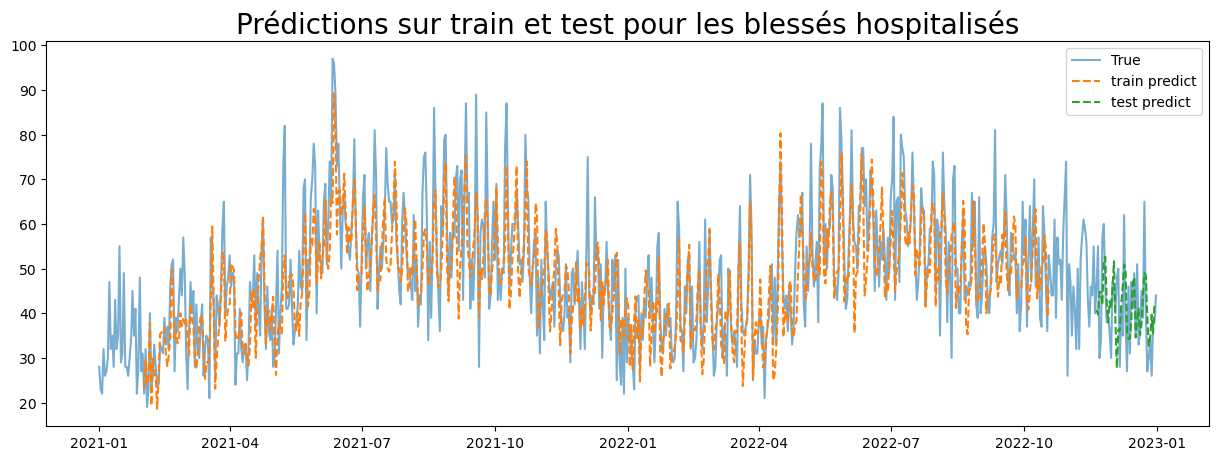

In [177]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1 : len(dataset_scaled)-1, :] = testPredict
 
# plot baseline and predictions
plt.figure(figsize = (15, 5))
plt.plot(df2.index, scaler.inverse_transform(dataset_scaled), label = 'True', alpha = 0.6)
plt.plot(df2.index, trainPredictPlot, "--", label = 'train predict')
plt.plot(df2.index, testPredictPlot, "--", label = 'test predict')
plt.legend()
plt.title("Prédictions sur train et test pour les blessés hospitalisés", {'fontsize' : 20})
plt.show()

Prédictions pour les 3 prochains mois

In [178]:
sample = np.reshape(testX_scaled[-1], (1, 1, look_back))
pred_scaled = []
n = 31                  # Prédiction pour le prochain mois
for i in range(n):
    next_step = model.predict(sample)
    add_sample = np.append(sample, next_step)[1:]
    sample = np.reshape(add_sample, (1, 1, add_sample.shape[0]))
    pred_scaled.append(next_step[0,0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

In [179]:
pred_scaled = np.array(pred_scaled)
pred_scaled.shape
pred_scaled = pred_scaled.reshape(len(pred_scaled), 1)

In [180]:
pred = scaler.inverse_transform(pred_scaled)

In [181]:
start = datetime.datetime.strptime("2023-01-01", "%Y-%m-%d")
date_generate = pd.date_range(start, periods = n)
date_generate

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-14', '2023-01-15', '2023-01-16',
               '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20',
               '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24',
               '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-28',
               '2023-01-29', '2023-01-30', '2023-01-31'],
              dtype='datetime64[ns]', freq='D')

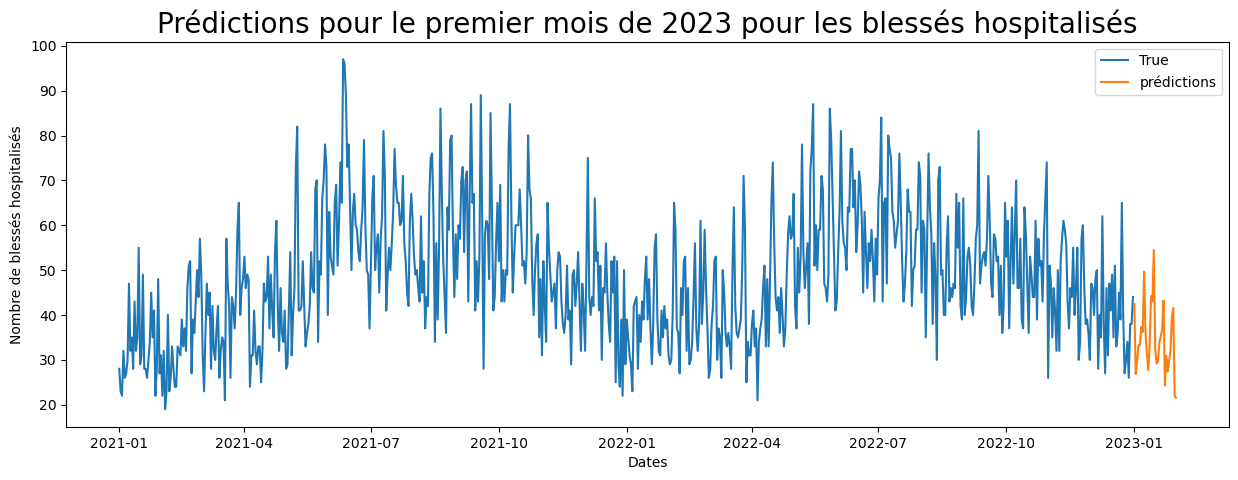

In [182]:
plt.figure(figsize = (15, 5))
plt.plot(df2.index, scaler.inverse_transform(dataset_scaled), label = 'True')
plt.plot(date_generate, pred, label = 'prédictions')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Nombre de blessés hospitalisés')
plt.title("Prédictions pour le premier mois de 2023 pour les blessés hospitalisés", {'fontsize' : 20})
plt.show()